In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib notebook
import numpy as np
import pandas as pd
from scipy import interpolate
from scipy import interpolate
import scipy as sp
import pickle

import xmeos
from xmeos import models
from xmeos import datamod
from xmeos import eoslib

from collections import OrderedDict
CONSTS = models.CONSTS

In [2]:
def write_output( file_name, data_tbl_a, data_units_a,
                 param_d, comment="" ):

    '''Write output.'''

    file_path = param_d['datadir']+file_name
    data_units = ' '.join([np.str(unit_val) for unit_val in data_units_a])
    header = param_d['header_default']+data_units
    size = '5 ' + str(int(data_tbl_a.shape[0])) + '\n'
    header = size + header
    if comment is not "":
        header = header + '\n' + comment
    np.savetxt( file_path, data_tbl_a, header=header)

#====================================================================
def write_data_table( file_name, data_cols_L, data_units_L,
                     param_d, comment="" ):

    '''Write data table with scale factors for each column.

    Input:
        file_name: string giving path to data file
        data_cols_L: list of arrays defining each column
        data_units_L: list of scale factors or string IDs (keys for param_d)
            referring to each scale factor
        param_d: dictionary containing output header and scale 
            factor info'''

    data_units_a = []
    for units in data_units_L:
        if isinstance( units, str ):
            data_units_a.append( param_d[units] )
        else:
            data_units_a.append( units )

    data_units_a = np.array( data_units_a )
    data_tbl_a = np.vstack( data_cols_L ).T
    write_output( file_name, data_tbl_a, data_units_a, param_d, comment=comment )
    
    
def get_output_constants(mass_avg, datadir):
    Nmol=6.0221413e+23
    output_d = OrderedDict()
    output_d['header_default'] = "Pressure, Entropy, Quantity\n"\
        "column * scaling factor should be SI units\n"\
        "scaling factors (constant) for each column given on line below\n"
    #output_d['datadir'] = 'data/lookup/lookup-rough/'
    #output_d['datadir'] = 'data/lookup/lookup-hires/'
    # output_d['datadir'] = 'data/lookup/lookup-hires-RTmelt/'
    output_d['datadir'] = datadir

    # NOTE: All extensive quantities changed from per atom to per unit mass
    # assert 'mass_avg' in param_d, "'mass_avg' must be set in param_d " \
    #     "in order to report extensive quantities per unit mass"
    # assert 'Nmol' in param_d, "'Nmol' is unset in param_d"

    # All output constants in mks units
    output_d['1'] = 1 # No unit change
    output_d['g'] = 1e-3 # mass [g] -> [kg]
    output_d['per_mass']  = Nmol/(mass_avg*output_d['g'])

    output_d['GPa'] = 1e9 # P:  [GPa] -> [Pa]
    output_d['GPa-1'] = 1e-9 # 1/P:  [1/GPa] -> [1/Pa]
    output_d['eV'] = 1.60217657e-19 \
        *output_d['per_mass'] # E, H, T*S, T*Cp:  [eV/atom] -> [J/kg]
    output_d['g_cc'] = 1e3 # rho:  [g/cc] -> [kg/m^3]
    return output_d


def write_all_data_tables(phasename, props, datadir='./'):
    """
    Write phase-specific data files
    """

    output = get_output_constants(props['molar_mass'], datadir)
    
    write_data_table('temperature_' + phasename + '.dat',
                     (props[key].ravel() for key in 
                      ('P', 'S', 'T')),
                     ('GPa', 'eV', 1), output)
    write_data_table('density_' + phasename + '.dat',
                     (props[key].ravel() for key in 
                      ('P', 'S', 'rho')),
                     ('GPa', 'eV','g_cc'), output)
    write_data_table('heat_capacity_' + phasename + '.dat',
                     (props[key].ravel() for key in 
                      ('P', 'S', 'C_P')),
                     ('GPa','eV','eV'), output)
    write_data_table('thermal_exp_' + phasename + '.dat',
                     (props[key].ravel() for key in 
                      ('P', 'S', 'alpha')),
                     ('GPa','eV',1), output)
    write_data_table('adiabat_temp_grad_'+phasename+'.dat',
                     (props[key].ravel() for key in 
                      ('P', 'S', 'dTdP_S')),
                     ('GPa','eV','GPa-1'), output)
    pass

In [3]:
# 5 301
# Pressure, Entropy, Quantity
# column * scaling factor should be SI units
# scaling factors (constant) for each column given on line below
# 55692628932.82327 2993.025100070677


In [4]:
def volume(P, T, eos_mod, Vinit=None, TOL=1e-3, bounds_error=True):


    def press_diff(V, P=P, T=T):
        return eos_mod.press(V, T) - P

    def press_diff_sqr(V, P=P, T=T):
        return (eos_mod.press(V, T) - P)**2

    def press_deriv(V, P=P, T=T):
        K = eos_mod.bulk_mod(V, T)
        dPdV = -K/V
        return dPdV

    
    if Vinit is None:
        V0, = eos_mod.get_param_values(param_names='V0')
        V_min0 = 0.8*V0
    else:
        V_min0 = Vinit
        
    V_min = sp.optimize.fmin(press_diff, V_min0, disp=False)

    #assert np.isscalar(Vinit), 'Vinit must be a scalar val.'
    # V = sp.optimize.fsolve(press_diff, Vinit, fprime=press_deriv)
    
    #V_min = sp.optimize.fmin(press_diff, Vinit, disp=False)

    if +press_diff(V_min) > +TOL:
        if bounds_error:
            raise ValueError(
                'The EOS is being sampled at an unphysical '
                'location! The target pressure is not accesible '
                'at this temperature.'
            )
        V = np.nan

    elif Vinit is None:
        output = sp.optimize.minimize(
            press_diff_sqr, [0.8*V_min], bounds=[(None, V_min)],
            options={'disp':False})
        V, = output.x

    else:
        #output = sp.optimize.minimize(
        #    press_diff_sqr, [Vinit], bounds=[(None, V_min)],
        #    options={'disp':False})
        #V, = output.x
        V = sp.optimize.fsolve(press_diff, Vinit, fprime=press_deriv)
    return V


In [5]:
def adjust_fusion_entropy(liq_eos, S_fus0, P_fus0, T_fus0, Vinit=9):
    Vliq_fus0 = volume(P_fus0, T_fus0, liq_eos, Vinit=Vinit)[0]
    S0 = liq_eos_S11.get_param_values('S0')
    
    S0 = liq_eos.get_param_values('S0')
    dS_adj = liq_eos.entropy(Vliq_fus0, T_fus0) - S_fus0
    
    S0 -= dS_adj
    liq_eos.set_param_values(param_names='S0', param_values=S0)
    print('S_fus0 diff = ', 
          liq_eos.entropy(Vliq_fus0, T_fus0)-S_fus0)

In [6]:
sol_eos = eoslib.MgPv_Mosenfelder2009()

In [7]:
analysis_file = 'data/analysis.pkl'
with open(analysis_file, 'rb') as f:
    analysis = pickle.load(f)

In [8]:
datamodel = analysis['datamodel']
datamodel_dK09 = analysis['datamodel_dK09']
data = datamodel['data']
liq_eos_S11 = datamodel['eos_mod']
liq_eos_dK09 = datamodel_dK09['eos_mod']

# eos_mod.apply_electronic = True
# eos_mod_dK09.apply_electronic = True
liq_eos_S11.apply_electronic = False
liq_eos_dK09.apply_electronic = False

In [9]:
P_fus0 = 25
T_fus0 = 2900
dS_fus=1.5

Vsol_fus0 = volume(P_fus0, T_fus0, sol_eos)
S_sol0 = sol_eos.entropy(Vsol_fus0, T_fus0)
S_fus0 = S_sol0 + dS_fus*CONSTS['kboltz']

adjust_fusion_entropy(liq_eos_S11, S_fus0, P_fus0, T_fus0, Vinit=9)
adjust_fusion_entropy(liq_eos_dK09, S_fus0, P_fus0, T_fus0, Vinit=9)

S_fus0 diff =  [0.]
S_fus0 diff =  [-5.42101086e-20]


In [10]:
def get_adiabatic_props(Pgrid, Tfoot_grid, eos):
    Vad_grid, Tad_grid = eos.adiabatic_path_grid(Tfoot_grid, Pgrid)
    props = eos.material_properties(Vad_grid, Tad_grid)
    props['molar_mass'] = eos.molar_mass
    return props

In [11]:
# Original data tables:
# dP = 1/2 GPa
# dT = 30 K
# roughly 300 Press pts by 300 entropy pts = 10^5 data values
# For 

Pgrid = np.arange(0,1.01e3,0.5)
Tfoot_grid_liq = np.arange(1e3,4401,30)
Tfoot_grid_sol = np.arange(260,4001,30)

In [12]:
# sol_props = get_adiabatic_props(Pgrid, Tfoot_grid_sol, sol_eos)

In [13]:
# Pgrid = np.arange(0, 1.01e3, 0.5)
# Tfoot_grid_liq = np.arange(1e3,3850,30)
# liq_props = get_adiabatic_props(Pgrid, Tfoot_grid_liq, liq_eos_dK09)

In [14]:
# write_all_data_tables('solid', sol_props, 
#                       datadir='data_tables/1TPa-dK09-elec-free/')

In [15]:
# write_all_data_tables('melt', liq_props, 
#                       datadir='data_tables/1TPa-dK09-elec-free/')

# Calculate Andrault-like melting bounds

In [16]:
H13_liq = pd.read_csv('data/Hamano2013-liquidus.csv')
H13_sol = pd.read_csv('data/Hamano2013-solidus.csv')
S09_liq = pd.read_csv('data/Stixrude2009-liquidus.csv')
S09_sol = pd.read_csv('data/Stixrude2009-solidus.csv')
A11_liq = pd.read_csv('data/Andrault2011-liquidus.csv')
A11_sol = pd.read_csv('data/Andrault2011-solidus.csv')



In [17]:
def overwrite_zero_val(table):
    y0 = sp.interpolate.interp1d(table['P'], table['T'], fill_value='extrapolate')(0)
    table['P'][0] = 0.0
    table['T'][0] = y0
    
overwrite_zero_val(H13_liq)
overwrite_zero_val(H13_sol)
overwrite_zero_val(S09_liq)
overwrite_zero_val(S09_sol)

In [18]:
slope_liq = (4700-2700)/(140-25)
P0_liq = 25.0
T0_liq = 2700.0
T_liq = slope_liq*(Pgrid-P0_liq)+T0_liq
T_sol = T_liq/1.09

<IPython.core.display.Javascript object>


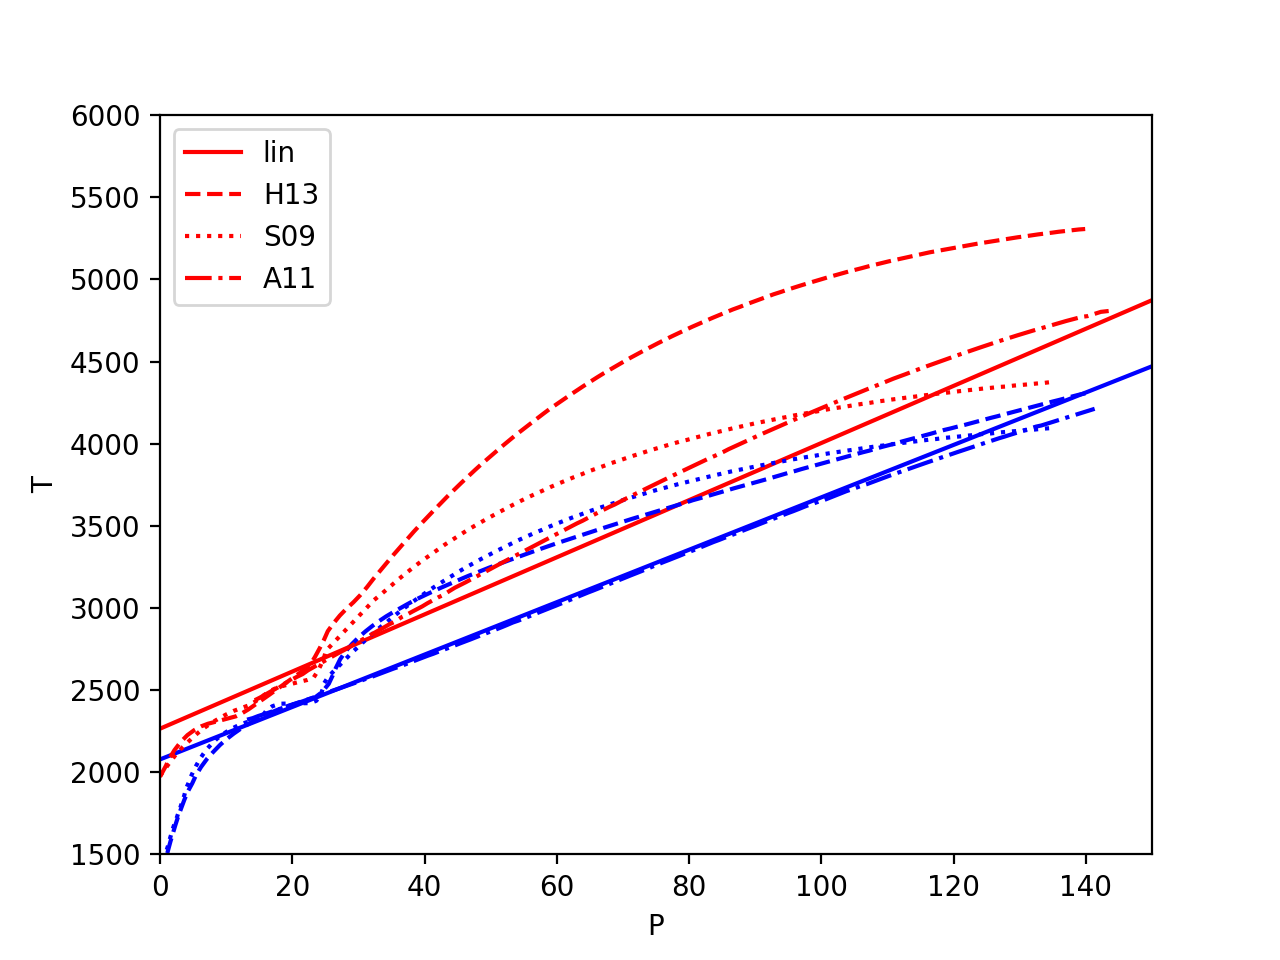

In [19]:
plt.figure()
plt.plot(Pgrid, T_liq, 'r-',label='lin')
plt.plot(Pgrid, T_sol, 'b-',label='')
plt.plot(H13_liq['P'], H13_liq['T'], 'r--', label='H13')
plt.plot(H13_sol['P'], H13_sol['T'], 'b--', label='')
plt.plot(S09_liq['P'], S09_liq['T'], 'r:', label='S09')
plt.plot(S09_sol['P'], S09_sol['T'], 'b:', label='')
plt.plot(A11_liq['P'], A11_liq['T'], 'r-.', label='A11')
plt.plot(A11_sol['P'], A11_sol['T'], 'b-.', label='')
plt.xlim(0,150)
plt.ylim(1500,6000)
plt.legend()
plt.xlabel('P')
plt.ylabel('T')

<IPython.core.display.Javascript object>


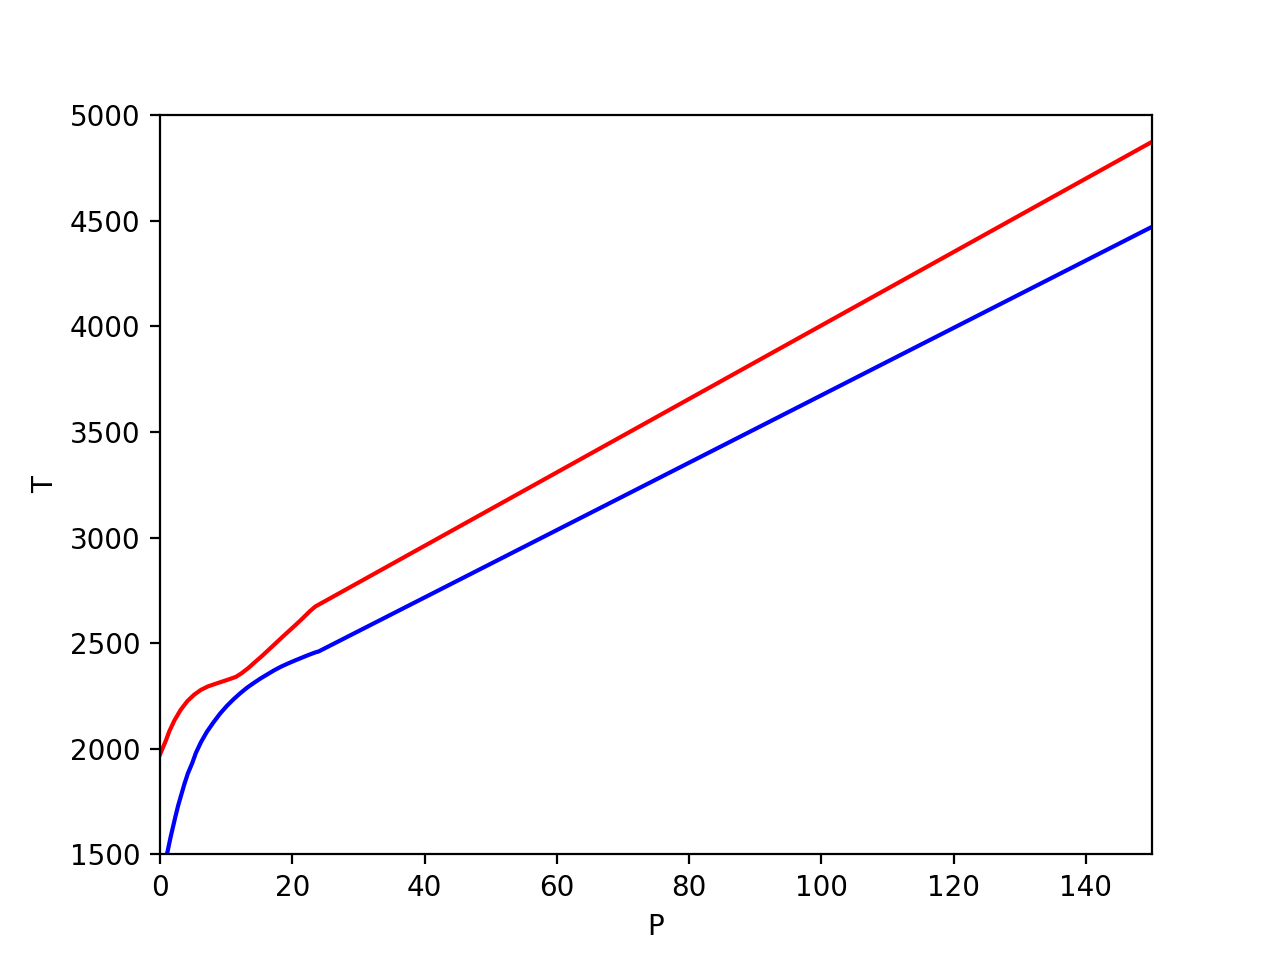

In [20]:
Pth_liq = 23.0
Pth_sol = 23.5

Pmantle_liq = np.hstack([H13_liq['P'][H13_liq['P']<Pth_liq], 
                         Pgrid[Pgrid>Pth_liq]])
Tmantle_liq = np.hstack([H13_liq['T'][H13_liq['P']<Pth_liq], 
                         T_liq[Pgrid>Pth_liq]])
Pmantle_sol = np.hstack([H13_sol['P'][H13_sol['P']<Pth_sol], 
                         Pgrid[Pgrid>Pth_sol]])
Tmantle_sol = np.hstack([H13_sol['T'][H13_sol['P']<Pth_sol], 
                         T_sol[Pgrid>Pth_sol]])

plt.figure()
plt.plot(Pmantle_liq, Tmantle_liq, 'r-',
        Pmantle_sol, Tmantle_sol, 'b-')
plt.xlim(0, 150)
plt.ylim(1500,5000)
plt.xlabel('P')
plt.ylabel('T')

In [497]:
def poly_smooth_curve(xbnds, fun_left, fun_right, coef4=0.0, coef5=0.0):
    
    
    xfrac=.01
    dx = 0.5*xfrac*np.diff(xbnds)
    x0, x1 = xbnds[:]
    
    # remap x to [-1,1] range
    
    y0 = fun_left(x0)
    y1 = fun_right(x1)
    
    
    
    # dydx0 = (y0-fun_left(x0-dx))/dx
    # dydx1 = (y1-fun_right(x1-dx))/dx
    dydx0 = (y0-fun_left(x0-dx))/xfrac
    dydx1 = (y1-fun_right(x1-dx))/xfrac
    
    # yfit = np.array([y0, dydx0, y1, dydx1])
    # Mfit = np.array([
    #     [x0**3, x0**2, x0, 1.0],
    #     [3*x0**2, 2*x0, 1.0, 0.0],
    #     [x1**3, x1**2, x1, 1.0],
    #     [3*x1**2, 2*x1, 1.0, 0.0]
    # ])
    
    # Mfit = np.array([
    #     [-1, +1, -1, 1],
    #     [3*(+1), 2*(-1), 1, 0],
    #     [+1, +1, +1, 1],
    #     [3*(+1), 2*(+1), 1, 0]
    # ])
    
    yfit = np.array([y0, dydx0, y1, dydx1, coef4, coef5])
    Mfit = np.array([
        [-1, +1, -1, +1, -1, 1],
        [5*(+1), 4*(-1), 3*(+1), 2*(-1), 1, 0],
        [+1, +1, +1, +1, +1, 1],
        [5*(+1), 4*(+1), 3*(+1), 2*(+1), 1, 0],
        [0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0]
    ])
    
    # print(Mfit)
    
    # coef = np.linalg.solve(Mfit, yfit)
    output = sp.linalg.lstsq(Mfit, yfit)
    coef = output[0]
    
    def fun(x, xbnds=xbnds, coef=coef):
        xrange = np.diff(xbnds)
        xfrac = (x-xbnds[0])/xrange
        xscl = 2*xfrac - 1
        y = np.polyval(coef, xscl)
        return y
    
    return fun, coef

In [771]:
order=5
coef_exp = np.arange(order,-.1,-1)

ix = -1
ix = +1
# ix = -.5
deriv_exp = np.maximum(coef_exp-1,0)
ix_wts = (ix*np.ones(order+1))**coef_exp
ideriv_wts = coef_exp*(ix*np.ones(order+1))**deriv_exp
ideriv_wts

array([5., 4., 3., 2., 1., 0.])

In [497]:
def constrain_poly_smooth_curve(xbnds, fun_left, fun_right, order=5):
    
    
    xfrac=.01
    dx = 0.5*xfrac*np.diff(xbnds)
    x0, x1 = xbnds[:]
    
    # remap x to [-1,1] range
    
    y0 = fun_left(x0)
    y1 = fun_right(x1)
    
    
    
    # dydx0 = (y0-fun_left(x0-dx))/dx
    # dydx1 = (y1-fun_right(x1-dx))/dx
    dydx0 = (y0-fun_left(x0-dx))/xfrac
    dydx1 = (y1-fun_right(x1-dx))/xfrac
    
    # yfit = np.array([y0, dydx0, y1, dydx1])
    # Mfit = np.array([
    #     [x0**3, x0**2, x0, 1.0],
    #     [3*x0**2, 2*x0, 1.0, 0.0],
    #     [x1**3, x1**2, x1, 1.0],
    #     [3*x1**2, 2*x1, 1.0, 0.0]
    # ])
    
    # Mfit = np.array([
    #     [-1, +1, -1, 1],
    #     [3*(+1), 2*(-1), 1, 0],
    #     [+1, +1, +1, 1],
    #     [3*(+1), 2*(+1), 1, 0]
    # ])
    
    coef_exp = np.arange(order,0)
    -np.ones(order+1)
    
    yfit = np.array([y0, dydx0, y1, dydx1, coef4, coef5])
    Mfit = np.array([
        [-1, +1, -1, +1, -1, 1],
        [5*(+1), 4*(-1), 3*(+1), 2*(-1), 1, 0],
        [+1, +1, +1, +1, +1, 1],
        [5*(+1), 4*(+1), 3*(+1), 2*(+1), 1, 0],
        [0, 1, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0]
    ])
    
    # print(Mfit)
    
    # coef = np.linalg.solve(Mfit, yfit)
    output = sp.linalg.lstsq(Mfit, yfit)
    coef = output[0]
    
    def fun(x, xbnds=xbnds, coef=coef):
        xrange = np.diff(xbnds)
        xfrac = (x-xbnds[0])/xrange
        xscl = 2*xfrac - 1
        y = np.polyval(coef, xscl)
        return y
    
    return fun, coef

In [772]:
# Smoothing bounds leaving Trans Zone intact
# Pbnds_smth_liq = [11.5, 23.0]
# Pbnds_smth_sol = [21.5, 25.5]

# Smoothing bounds masking transition zone/upper mantle variability in entropy
# Smoothing bounds masking transition zone/upper mantle variability in entropy
Pbnds_smth_liq = [4.0, 23.0]
# Pbnds_smth_sol = [7.0, 30.0]
Pbnds_smth_sol = [4.0, 28.0]
# coef4=-120, coef5=+55
# 8, -10, +20

In [773]:
fun_liq_loP = sp.interpolate.interp1d(H13_liq['P'], H13_liq['T'], 
                                      kind='cubic', fill_value='extrapolate' )
fun_liq_hiP = sp.interpolate.interp1d(Pgrid, T_liq,
                                      kind='cubic', fill_value='extrapolate' )


fun_liq, coef_liq = poly_smooth_curve(Pbnds_smth_liq, fun_liq_loP, fun_liq_hiP)
coef_liq

array([-3.55271368e-13,  1.56319402e-13,  1.79922671e+01, -4.64680526e+01,
        2.04176695e+02,  2.48951648e+03])

In [879]:
fun_sol_loP = sp.interpolate.interp1d(H13_sol['P'], H13_sol['T'], 
                                      kind='cubic', fill_value='extrapolate' )
fun_sol_hiP = sp.interpolate.interp1d(Pgrid, T_sol,
                                      kind='cubic', fill_value='extrapolate' )

fun_sol, coef_sol = poly_smooth_curve(Pbnds_smth_sol, fun_sol_loP, fun_sol_hiP, coef4=-135, coef5=+68)
coef_sol

array([  68.        , -135.        ,   37.74880206,   26.88434194,
        224.44881099, 2302.84824045])

<IPython.core.display.Javascript object>


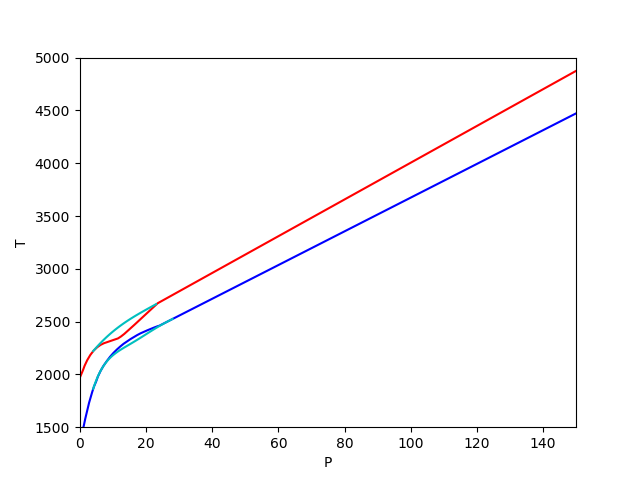

In [880]:
Pmod_liq = np.linspace(*Pbnds_smth_liq, 101)
Pmod_sol = np.linspace(*Pbnds_smth_sol, 101)
plt.figure()
plt.plot(Pmantle_liq, Tmantle_liq, 'r-',
        Pmantle_sol, Tmantle_sol, 'b-')
plt.plot(Pmod_liq, fun_liq(Pmod_liq), 'c-')
plt.plot(Pmod_sol, fun_sol(Pmod_sol), 'c-')
plt.xlim(0, 150)
plt.ylim(1500,5000)
plt.xlabel('P')
plt.ylabel('T')

In [881]:

Pmantle_liq_adj = np.hstack([Pmantle_liq[Pmantle_liq < Pmod_liq[0]], 
                             Pmod_liq, 
                             Pmantle_liq[Pmantle_liq > Pmod_liq[-1]]])
     
Tmantle_liq_adj = np.hstack([Tmantle_liq[Pmantle_liq < Pmod_liq[0]], 
                             fun_liq(Pmod_liq),
                             Tmantle_liq[Pmantle_liq > Pmod_liq[-1]]])
    

    
Pmantle_sol_adj = np.hstack([Pmantle_sol[Pmantle_sol < Pmod_sol[0]], 
                             Pmod_sol, 
                             Pmantle_sol[Pmantle_sol > Pmod_sol[-1]]])
     
Tmantle_sol_adj = np.hstack([Tmantle_sol[Pmantle_sol < Pmod_sol[0]], 
                             fun_sol(Pmod_sol),
                             Tmantle_sol[Pmantle_sol > Pmod_sol[-1]]])
     

In [882]:
fun_liq_adj = sp.interpolate.interp1d(Pmantle_liq_adj, Tmantle_liq_adj)
fun_sol_adj = sp.interpolate.interp1d(Pmantle_sol_adj, Tmantle_sol_adj)

In [989]:
# Pvals = np.arange(0,150,2)
Pvals = np.arange(0,1000,1)
# Pvals = np.arange(0,50,.5)
Tvals_liq = fun_liq_adj(Pvals)
Tvals_sol = fun_sol_adj(Pvals)

In [990]:
def eval_vol(Pvals, Tvals, mod_eos, Vinit=10.0):
    Vvals = np.zeros(Pvals.size)
    iV = Vinit
    for ind, (iP, iT) in enumerate(zip(Pvals, Tvals)):
        iV = volume(iP, iT, mod_eos, Vinit=iV)
        Vvals[ind] = iV
        
    return Vvals, Pvals, Tvals
    
# Vsol, Psol, Tsol = eval_vol(Pmantle_sol_adj[::10], Tmantle_sol_adj[::10], sol_eos, Vinit=9.0)
# Vliq, Pliq, Tliq = eval_vol(Pmantle_liq_adj[::10], Tmantle_liq_adj[::10], liq_eos_dK09, Vinit=12.0)
    
Vsol, Psol, Tsol = eval_vol(Pvals, Tvals_sol, sol_eos, Vinit=9.0)
Ssol = sol_eos.entropy(Vsol, Tsol)
Vliq, Pliq, Tliq = eval_vol(Pvals, Tvals_liq, liq_eos_dK09, Vinit=12.0)
Sliq = liq_eos_dK09.entropy(Vliq, Tliq)
                  

<IPython.core.display.Javascript object>


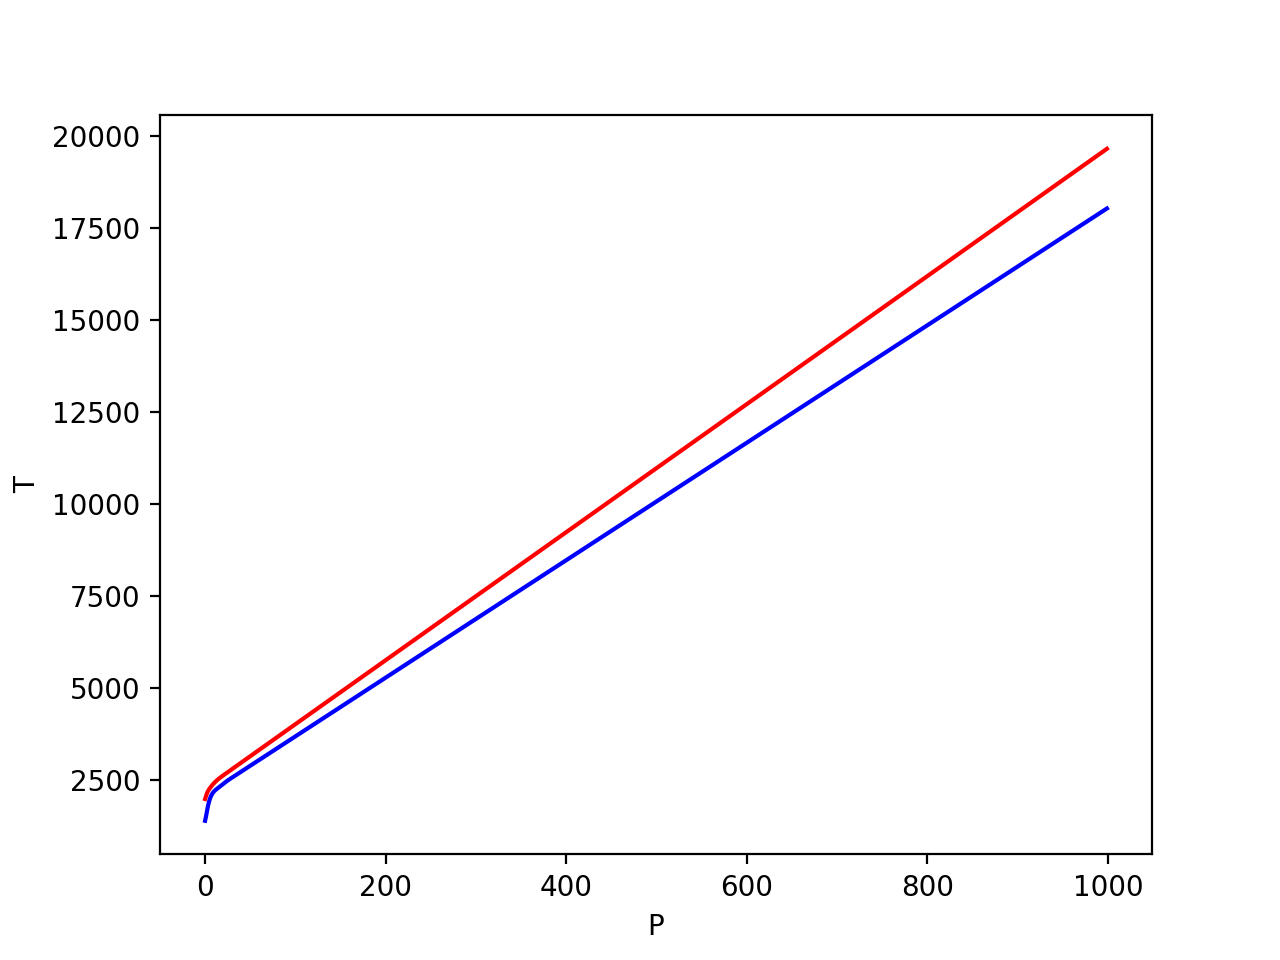

<IPython.core.display.Javascript object>


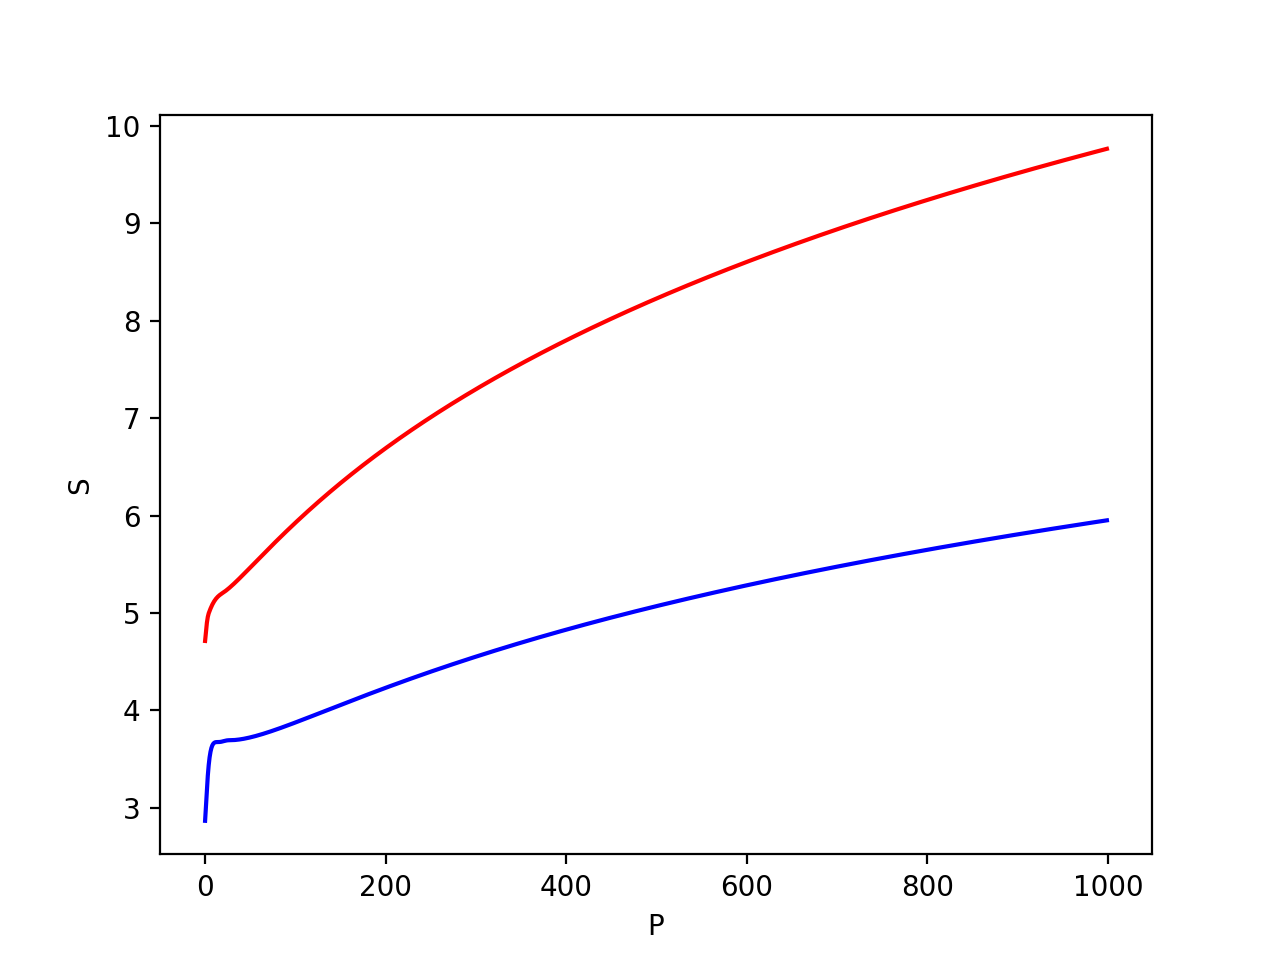

In [991]:
plt.figure()
plt.plot(Psol, Tsol, 'b-')
plt.plot(Pliq, Tliq, 'r-')
plt.xlabel('P')
plt.ylabel('T')

plt.figure()
plt.plot(Psol, Ssol/models.CONSTS['kboltz'], 'b-')
plt.plot(Pliq, Sliq/models.CONSTS['kboltz'], 'r-')
plt.xlabel('P')
plt.ylabel('S')



In [996]:
# Smoothing bounds leaving Trans Zone intact
# Pbnds_smth_liq = [11.5, 23.0]
# Pbnds_smth_sol = [21.5, 25.5]

# Smoothing bounds masking transition zone/upper mantle variability in entropy
# Smoothing bounds masking transition zone/upper mantle variability in entropy
Pbnds_smth_liq = [4.0, 23.0]
# Pbnds_smth_sol = [7.0, 30.0]
# Pbnds_smth_sol = [4.0, 28.0]
Pbnds_smth_sol = [10.0, 28.0]
# coef4=-120, coef5=+55
# 8, -10, +20

In [997]:
Sfun_sol0 = sp.interpolate.interp1d(Psol, Ssol/models.CONSTS['kboltz'], 
                                      kind='cubic', fill_value='extrapolate' )

Sfun_sol, Scoef_sol = poly_smooth_curve(Pbnds_smth_sol, Sfun_sol0, Sfun_sol0, 
                                        coef4=-7e-3, coef5=+3e-3)
Scoef_sol

array([ 3.00000000e-03, -7.00000000e-03,  4.01087622e-03, -2.40439230e-03,
        6.62900355e-03,  3.68997921e+00])

<IPython.core.display.Javascript object>


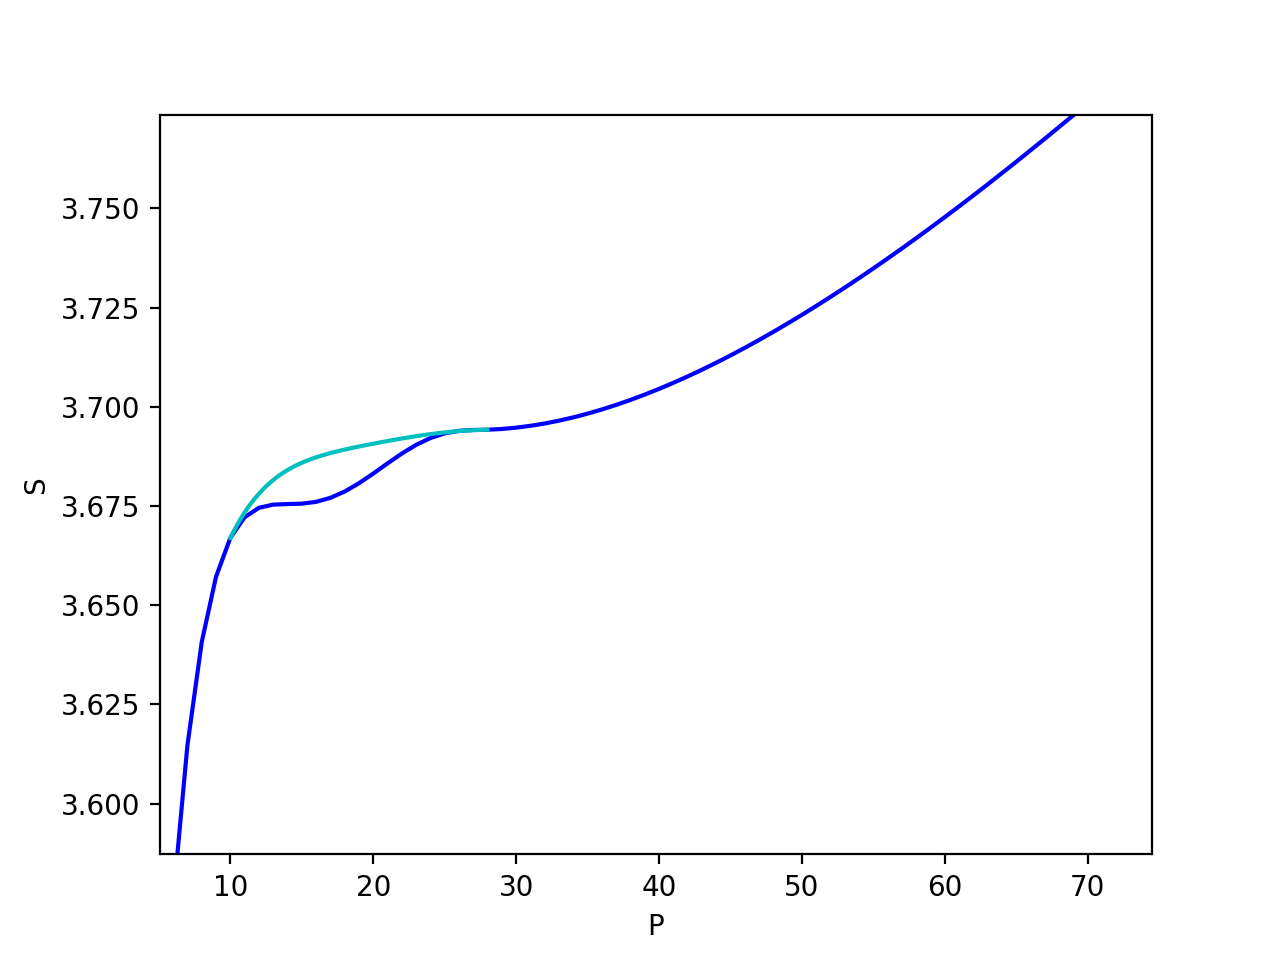

In [998]:
Pmod_sol = np.linspace(*Pbnds_smth_sol, 101)
plt.figure()

plt.plot(Pliq, Sliq/models.CONSTS['kboltz'], 'r-')
plt.plot(Psol, Ssol/models.CONSTS['kboltz'], 'b-')
plt.plot(Pmod_sol, Sfun_sol(Pmod_sol), 'c-')
# plt.xlim(8, 42)
# plt.ylim(3.65, 3.72)
plt.xlabel('P')
plt.ylabel('S')

In [999]:
Psol, Ssol/models.CONSTS['kboltz']

Pmantle_sol_adj = np.hstack([Psol[Psol < Pmod_sol[0]], 
                             Pmod_sol, 
                             Psol[Psol > Pmod_sol[-1]]])
     
Smantle_sol_adj = np.hstack([Ssol[Psol < Pmod_sol[0]], 
                             Sfun_sol(Pmod_sol)*models.CONSTS['kboltz'],
                             Ssol[Psol > Pmod_sol[-1]]])
     

<IPython.core.display.Javascript object>


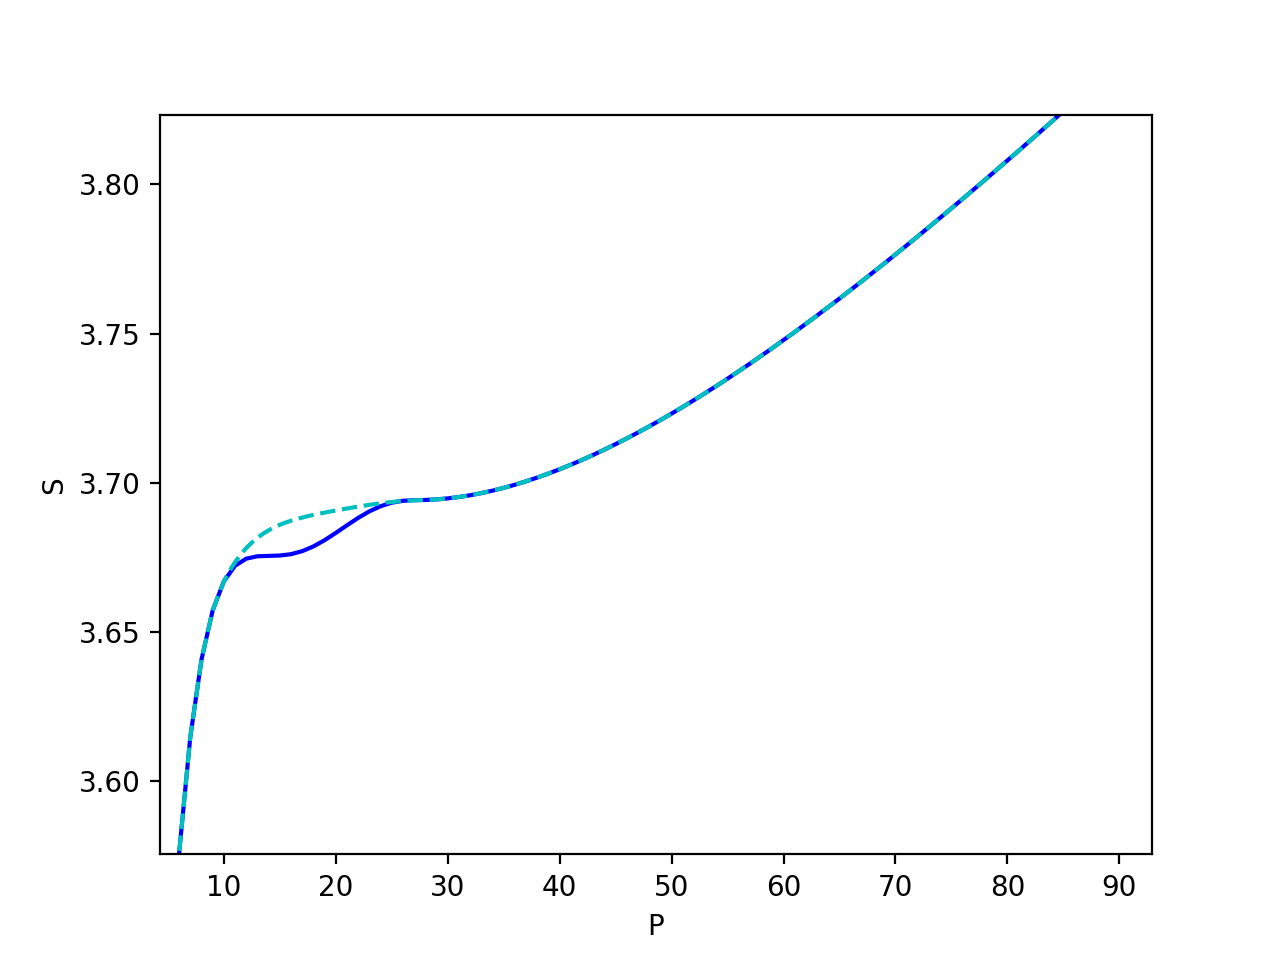

In [1000]:
plt.figure()

plt.plot(Psol, Ssol/models.CONSTS['kboltz'], 'b-')
plt.plot(Pmantle_sol_adj, Smantle_sol_adj/models.CONSTS['kboltz'], 'c--')
# plt.xlim(8, 42)
# plt.ylim(3.65, 3.72)
plt.xlabel('P')
plt.ylabel('S')

In [1001]:
Sfun_liq_adj = sp.interpolate.interp1d(Pliq, Sliq)
Sfun_sol_adj = sp.interpolate.interp1d(Pmantle_sol_adj, Smantle_sol_adj)

In [1002]:
# Pvals = np.arange(0,150,2)
Pvals = np.arange(0,1000,1)
# Pvals = np.arange(0,50,.5)
Svals_liq = Sfun_liq_adj(Pvals)
Svals_sol = Sfun_sol_adj(Pvals)

<IPython.core.display.Javascript object>


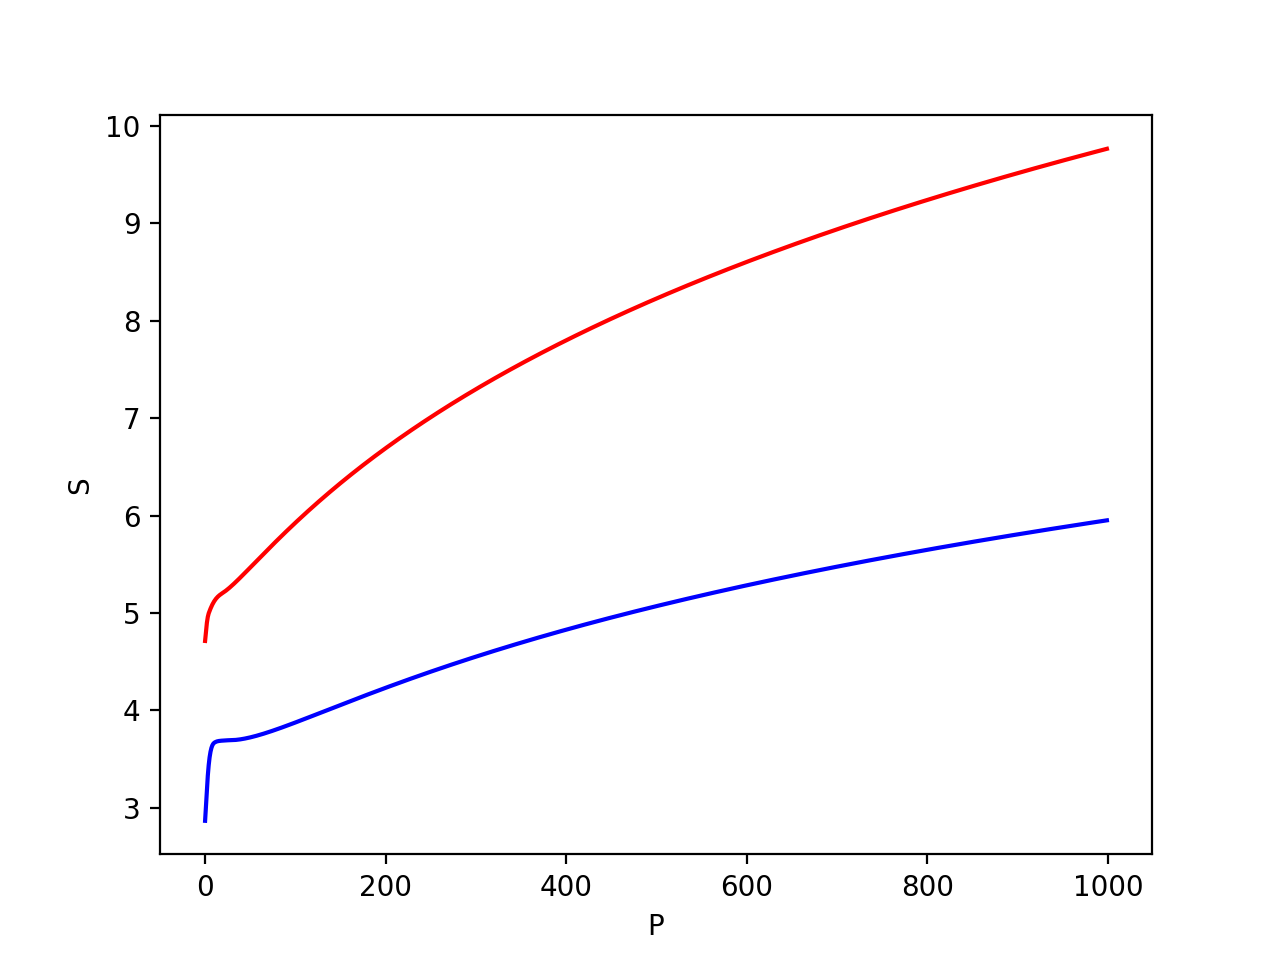

In [1005]:
plt.figure()
plt.plot(Pvals, Svals_liq/models.CONSTS['kboltz'], 'r-')
plt.plot(Pvals, Svals_sol/models.CONSTS['kboltz'], 'b-')
plt.xlabel('P')
plt.ylabel('S')



In [1007]:
datadir='./data_tables/1TPa-dK09-elec-free/'
molar_mass = sol_eos.molar_mass
output = get_output_constants(molar_mass, datadir)
write_data_table('solidus_A11_H13.dat', (Pvals, Svals_sol), ('GPa', 'eV'), output)
write_data_table('liquidus_A11_H13.dat', (Pvals, Svals_liq), ('GPa', 'eV'), output)

# write_data_table('solidus_temp_A11_H13.dat', (Psol, Tsol), ('GPa', '1'), output)
# write_data_table('liquidus_temp_A11_H13.dat', (Pliq, Tliq), ('GPa', '1'), output)


In [887]:
# Pvals = np.arange(0,150,2)
Pvals = np.arange(0,1000,1)
# Pvals = np.arange(0,50,1)
Tvals_liq = fun_liq_adj(Pvals)
Tvals_sol = fun_sol_adj(Pvals)

In [888]:
def eval_vol(Pvals, Tvals, mod_eos, Vinit=10.0):
    Vvals = np.zeros(Pvals.size)
    iV = Vinit
    for ind, (iP, iT) in enumerate(zip(Pvals, Tvals)):
        iV = volume(iP, iT, mod_eos, Vinit=iV)
        Vvals[ind] = iV
        
    return Vvals, Pvals, Tvals
    
# Vsol, Psol, Tsol = eval_vol(Pmantle_sol_adj[::10], Tmantle_sol_adj[::10], sol_eos, Vinit=9.0)
# Vliq, Pliq, Tliq = eval_vol(Pmantle_liq_adj[::10], Tmantle_liq_adj[::10], liq_eos_dK09, Vinit=12.0)
    
# Vsol, Psol, Tsol = eval_vol(Pvals, Tvals_sol, sol_eos, Vinit=9.0)
# Ssol = sol_eos.entropy(Vsol, Tsol)
# Vliq, Pliq, Tliq = eval_vol(Pvals, Tvals_liq, liq_eos_dK09, Vinit=12.0)
# Sliq = liq_eos_dK09.entropy(Vliq, Tliq)
                 
Pbnd = Pbnds_smth_sol[1]
# dP = 0.1

def calc_d2S(Pbnd, coef, eos_mod, dP=0.1):
    Pvals = Pbnd + dP*np.array([-1,0,+1])
    Tvals = np.polyval(coef, Pvals)
    
    V, P, T = eval_vol(Pvals, Tvals, eos_mod, Vinit=9.0)
    S = eos_mod.entropy(V, T)/models.CONSTS['kboltz']
    
    Scoef = np.polyfit((P-Pbnd)/20.0, S, 2)
    Scurv = Scoef[0]
    return Scurv


def calc_d2S_jacobian(Pbnd, coef, eos_mod, dP=0.1):
    Scurv0 = calc_d2S(Pbnd, coef, eos_mod, dP=dP)
    Nparam = len(coef)
    J = np.zeros(Nparam)
    
    dparam = 1e-3
    for ind, idparam in enumerate(dparam*np.eye(Nparam)):
        dScurv0 = calc_d2S(Pbnd, coef+idparam, eos_mod, dP=0.1) - Scurv0
        J[ind] = dScurv0/dparam
        
    return J


In [299]:
d2S0 = calc_d2S(Pbnd, coef_sol, sol_eos)
J = calc_d2S_jacobian(Pbnd, coef_sol, sol_eos)

/Users/aswolf/Documents/projects/xmeos/xmeos/models/compress.py:483: RuntimeWarning: invalid value encountered in power
  press_a = 3/2*K0 * (vratio_a**(-7/3) - vratio_a**(-5/3)) * \
/Users/aswolf/Documents/projects/xmeos/xmeos/models/compress.py:484: RuntimeWarning: invalid value encountered in power
  (1 + 3/4*(KP0-4)*(vratio_a**(-2/3)-1))
/Users/aswolf/Documents/projects/xmeos/xmeos/models/gamma.py:239: RuntimeWarning: invalid value encountered in power
  gamma_a = gamma0 *(V_a/V0)**q


ValueError: The EOS is being sampled at an unphysical location! The target pressure is not accesible at this temperature.

<IPython.core.display.Javascript object>


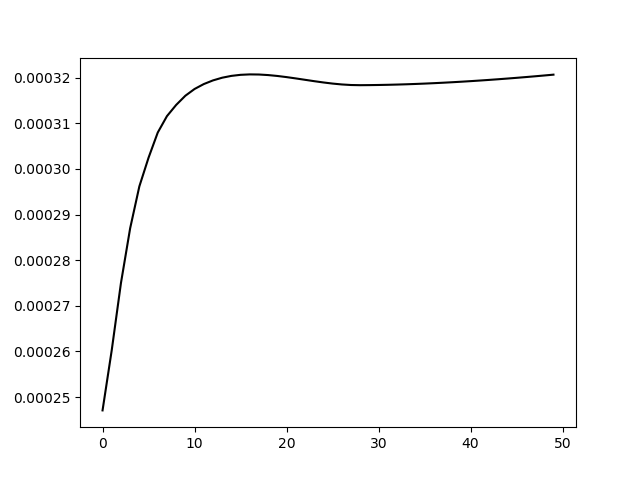

In [300]:
plt.figure()
plt.plot(Pvals, Ssol, 'k-')

<IPython.core.display.Javascript object>


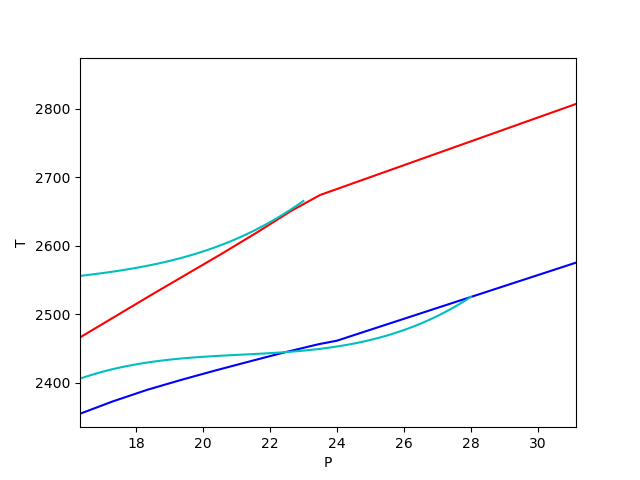

In [301]:
Pmod_liq = np.linspace(*Pbnds_smth_liq, 101)
Pmod_sol = np.linspace(*Pbnds_smth_sol, 101)
plt.figure()
plt.plot(Pmantle_liq, Tmantle_liq, 'r-',
        Pmantle_sol, Tmantle_sol, 'b-')
plt.plot(Pmod_liq, fun_liq(Pmod_liq), 'c-')
plt.plot(Pmod_sol, fun_sol(Pmod_sol), 'c-')
plt.xlim(0, 150)
plt.ylim(1500,5000)
plt.xlabel('P')
plt.ylabel('T')

In [226]:

Pmantle_liq_adj = np.hstack([Pmantle_liq[Pmantle_liq < Pmod_liq[0]], 
                             Pmod_liq, 
                             Pmantle_liq[Pmantle_liq > Pmod_liq[-1]]])
     
Tmantle_liq_adj = np.hstack([Tmantle_liq[Pmantle_liq < Pmod_liq[0]], 
                             np.polyval(coef_liq, Pmod_liq),
                             Tmantle_liq[Pmantle_liq > Pmod_liq[-1]]])
    

    
Pmantle_sol_adj = np.hstack([Pmantle_sol[Pmantle_sol < Pmod_sol[0]], 
                             Pmod_sol, 
                             Pmantle_sol[Pmantle_sol > Pmod_sol[-1]]])
     
Tmantle_sol_adj = np.hstack([Tmantle_sol[Pmantle_sol < Pmod_sol[0]], 
                             np.polyval(coef_sol, Pmod_sol),
                             Tmantle_sol[Pmantle_sol > Pmod_sol[-1]]])
     

<IPython.core.display.Javascript object>


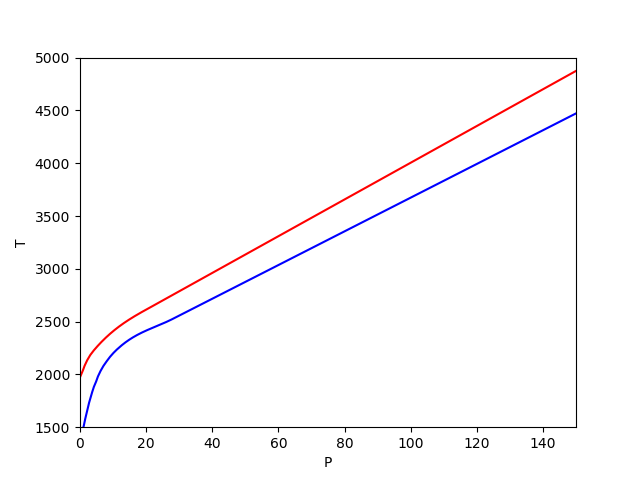

In [227]:
plt.figure()
plt.plot(Pmantle_liq_adj, Tmantle_liq_adj, 'r-',
        Pmantle_sol_adj, Tmantle_sol_adj, 'b-')

# plt.plot(H13_liq['P'], H13_liq['T'], 'm--', label='H13')
# plt.plot(H13_sol['P'], H13_sol['T'], 'c--', label='')
# 
# plt.plot(A11_liq['P'], A11_liq['T'], 'r-.', label='A11')
# plt.plot(A11_sol['P'], A11_sol['T'], 'b-.', label='')


plt.xlim(0, 150)
plt.ylim(1500,5000)
plt.xlabel('P')
plt.ylabel('T')



In [228]:
fun_liq_adj = sp.interpolate.interp1d(Pmantle_liq_adj, Tmantle_liq_adj)
fun_sol_adj = sp.interpolate.interp1d(Pmantle_sol_adj, Tmantle_sol_adj)

In [229]:
# Pvals = np.arange(0,150,2)
# Pvals = np.arange(0,1000,1)
Pvals = np.arange(0,50,1)
Tvals_liq = fun_liq_adj(Pvals)
Tvals_sol = fun_sol_adj(Pvals)

In [230]:
def eval_vol(Pvals, Tvals, mod_eos, Vinit=10.0):
    Vvals = np.zeros(Pvals.size)
    iV = Vinit
    for ind, (iP, iT) in enumerate(zip(Pvals, Tvals)):
        iV = volume(iP, iT, mod_eos, Vinit=iV)
        Vvals[ind] = iV
        
    return Vvals, Pvals, Tvals
    
# Vsol, Psol, Tsol = eval_vol(Pmantle_sol_adj[::10], Tmantle_sol_adj[::10], sol_eos, Vinit=9.0)
# Vliq, Pliq, Tliq = eval_vol(Pmantle_liq_adj[::10], Tmantle_liq_adj[::10], liq_eos_dK09, Vinit=12.0)
    
Vsol, Psol, Tsol = eval_vol(Pvals, Tvals_sol, sol_eos, Vinit=9.0)
Ssol = sol_eos.entropy(Vsol, Tsol)
Vliq, Pliq, Tliq = eval_vol(Pvals, Tvals_liq, liq_eos_dK09, Vinit=12.0)
Sliq = liq_eos_dK09.entropy(Vliq, Tliq)
                  

<IPython.core.display.Javascript object>


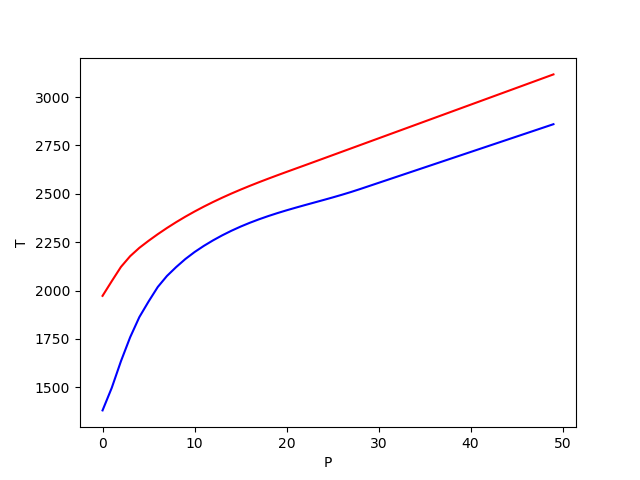

<IPython.core.display.Javascript object>


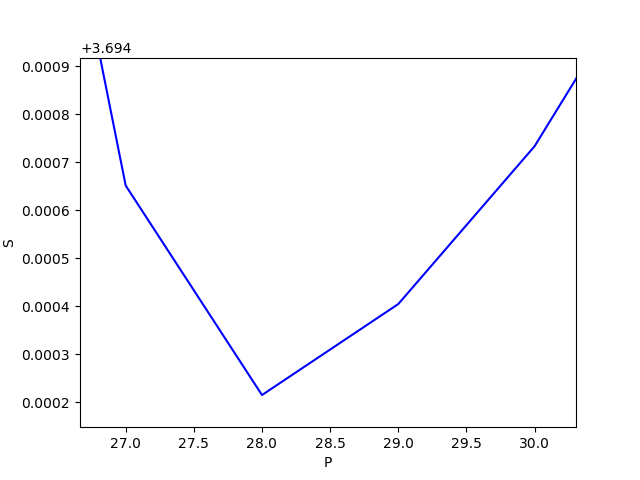

In [231]:
plt.figure()
plt.plot(Psol, Tsol, 'b-')
plt.plot(Pliq, Tliq, 'r-')
plt.xlabel('P')
plt.ylabel('T')

plt.figure()
plt.plot(Psol, Ssol/models.CONSTS['kboltz'], 'b-')
plt.plot(Pliq, Sliq/models.CONSTS['kboltz'], 'r-')
plt.xlabel('P')
plt.ylabel('S')



<IPython.core.display.Javascript object>


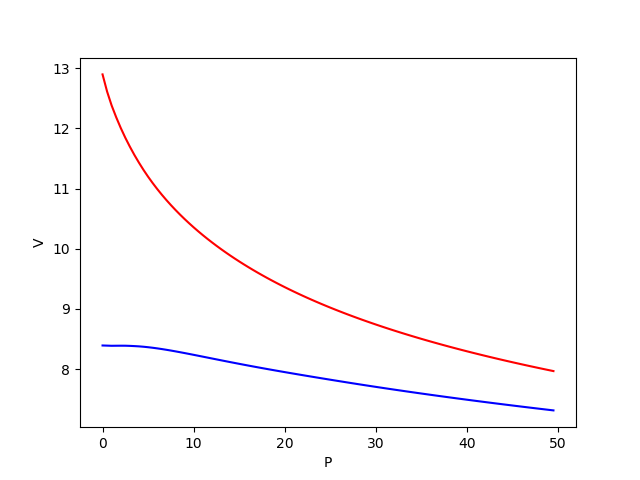

<IPython.core.display.Javascript object>


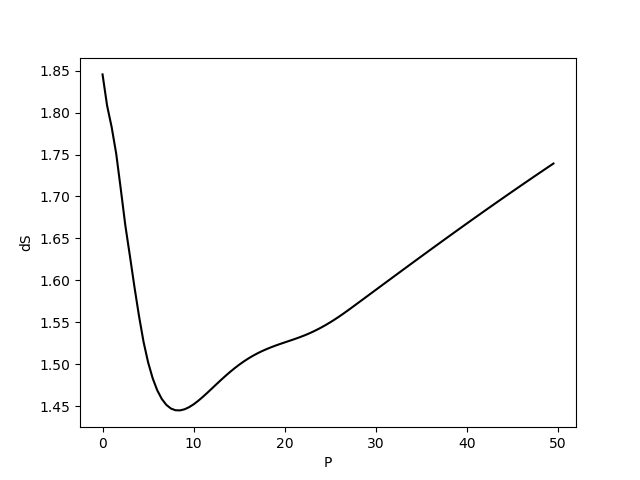

In [886]:

plt.figure()
plt.plot(Psol, Vsol, 'b-')
plt.plot(Pliq, Vliq, 'r-')
plt.xlabel('P')
plt.ylabel('V')


plt.figure()
plt.plot(Psol, (Sliq-Ssol)/models.CONSTS['kboltz'], 'k-')
plt.xlabel('P')
plt.ylabel('dS')

In [892]:
datadir='./data_tables/1TPa-dK09-elec-free/'
molar_mass = sol_eos.molar_mass
output = get_output_constants(molar_mass, datadir)
write_data_table('solidus_A11_H13.dat', (Psol, Ssol), ('GPa', 'eV'), output)
write_data_table('liquidus_A11_H13.dat', (Pliq, Sliq), ('GPa', 'eV'), output)

write_data_table('solidus_temp_A11_H13.dat', (Psol, Tsol), ('GPa', '1'), output)
write_data_table('liquidus_temp_A11_H13.dat', (Pliq, Tliq), ('GPa', '1'), output)


In [82]:
Psol, Ssol, Tsol
Pliq, Sliq, Tliq




(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 array([0.00040613, 0.00041392, 0.00042226, 0.0004274 , 0.00043055,
        0.00043279, 0.00043487, 0.00043677, 0.00043849, 0.00044002,
        0.00044138, 0.00044258, 0.00044364, 0.00044456, 0.00044538,
        0.0004461 , 0.00044675, 0.00044734, 0.00044788, 0.0004484 ,
        0.00044891, 0.00044943, 0.00044998, 0.00045056, 0.00045118,
        0.00045182, 0.00045248, 0.00045316, 0.00045386, 0.00045456,
        0.00045528, 0.00045601, 0.00045676, 0.00045751, 0.00045827,
        0.00045903, 0.00045981, 0.00046058, 0.00046137, 0.00046216,
        0.00046295, 0.00046375, 0.00046455, 0.00046535, 0.00046616,
        0.00046697, 0.00046778, 0.00046859, 0.00046941, 0.00047022]),
 array([1972.708714  , 2048.49471777, 2122.33931809, 2177.79611641,
        2220.8794666 , 2

In [16]:
adiabat_temp_grad_melt.dat
density_melt.dat
heat_capacity_melt.dat
temperature_melt.dat
thermal_exp_melt.dat

NameError: name 'adiabat_temp_grad_melt' is not defined

In [ ]:
adiabat_temp_grad_melt.dat
density_melt.dat
heat_capacity_melt.dat
temperature_melt.dat
thermal_exp_melt.dat

adiabat_temp_grad_solid.dat
density_solid.dat
heat_capacity_solid.dat
temperature_solid.dat
thermal_exp_solid.dat

liquidus_andrault2011.dat
solidus_andrault2011.dat

liquidus_stixrude2009.dat
solidus_stixrude2009.dat

In [24]:
write_data_table('test_output_density.dat', 
                 (props[key].ravel() for key in ('P', 'S', 'rho')),
                 ('GPa','eV','g_cc'), output_d, comment="" )

[[1.31793730e-07 1.88883733e-04 4.00932354e+00]
 [5.00001415e-01 1.88883732e-04 4.01762175e+00]
 [9.99999300e-01 1.88883734e-04 4.02586597e+00]
 ...
 [1.00850012e+03 4.98616710e-04 8.58934071e+00]
 [1.00900012e+03 4.98616710e-04 8.59061992e+00]
 [1.00950012e+03 4.98616710e-04 8.59189873e+00]]


In [18]:

cmap = plt.get_cmap('coolwarm', len(Tfoot_grid))
        
colors = cmap(np.linspace(0,1,len(Tfoot_grid)))

<IPython.core.display.Javascript object>


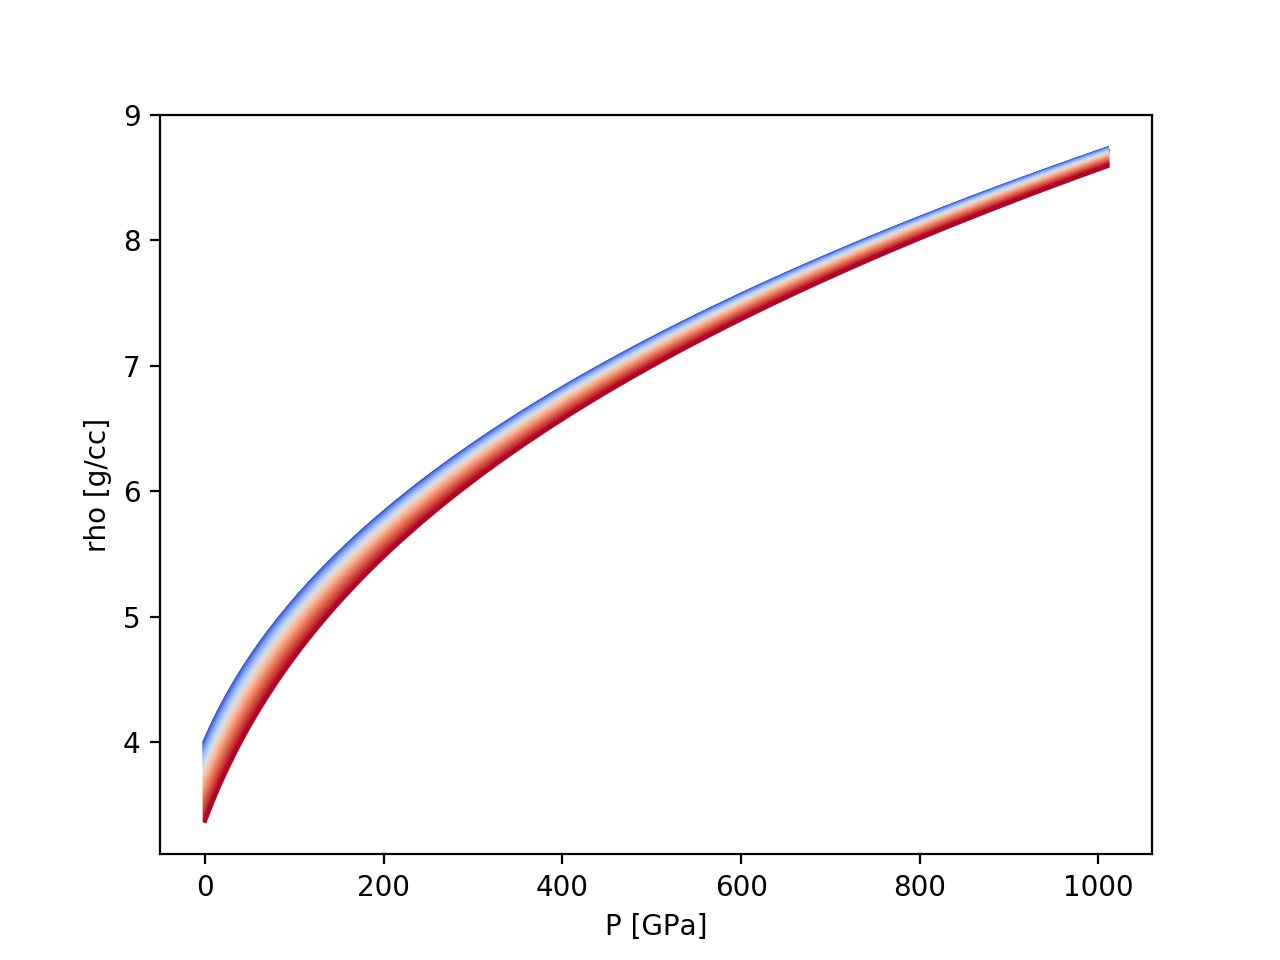

<IPython.core.display.Javascript object>


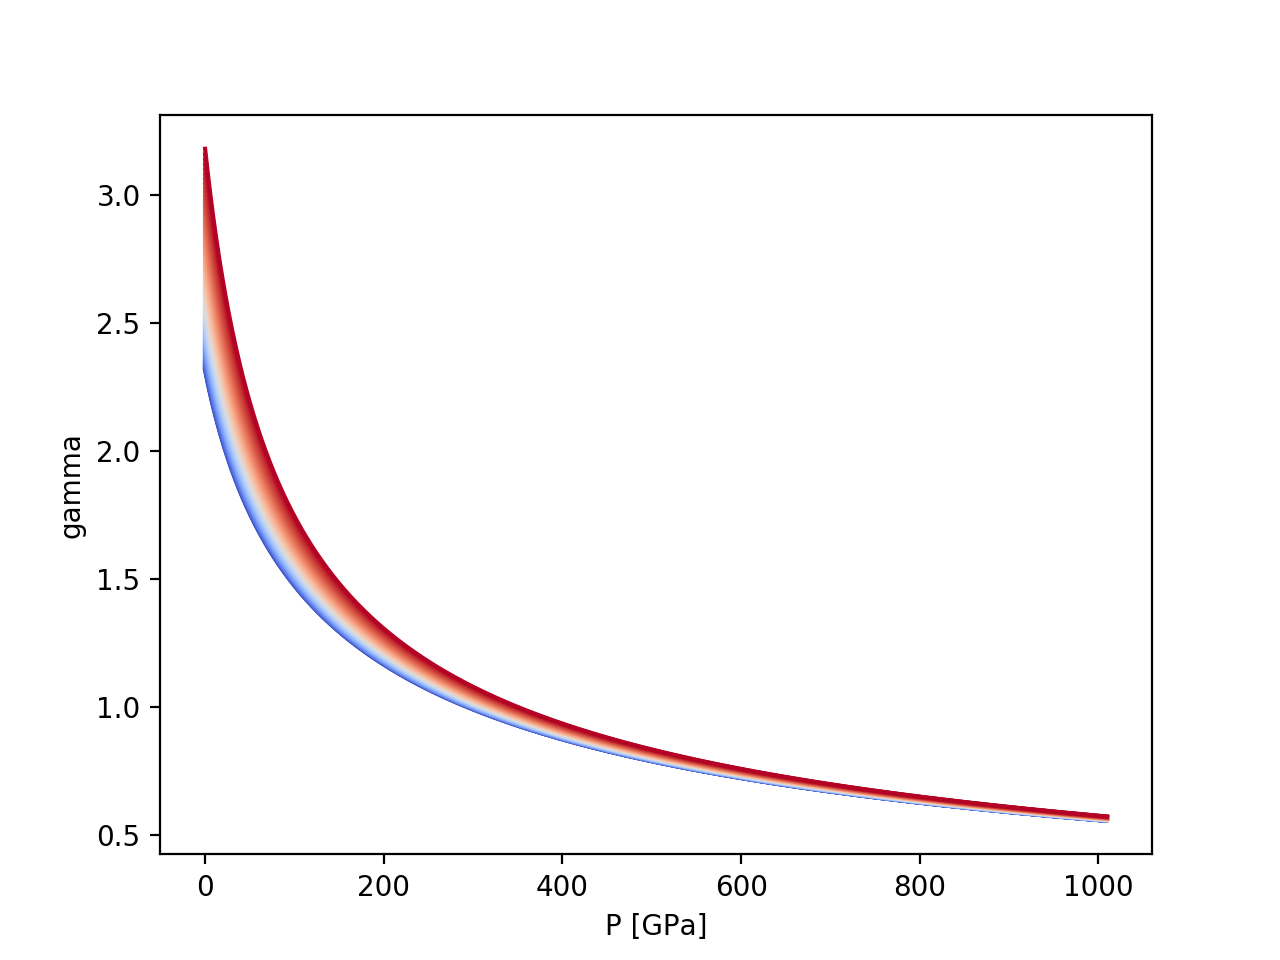

<IPython.core.display.Javascript object>


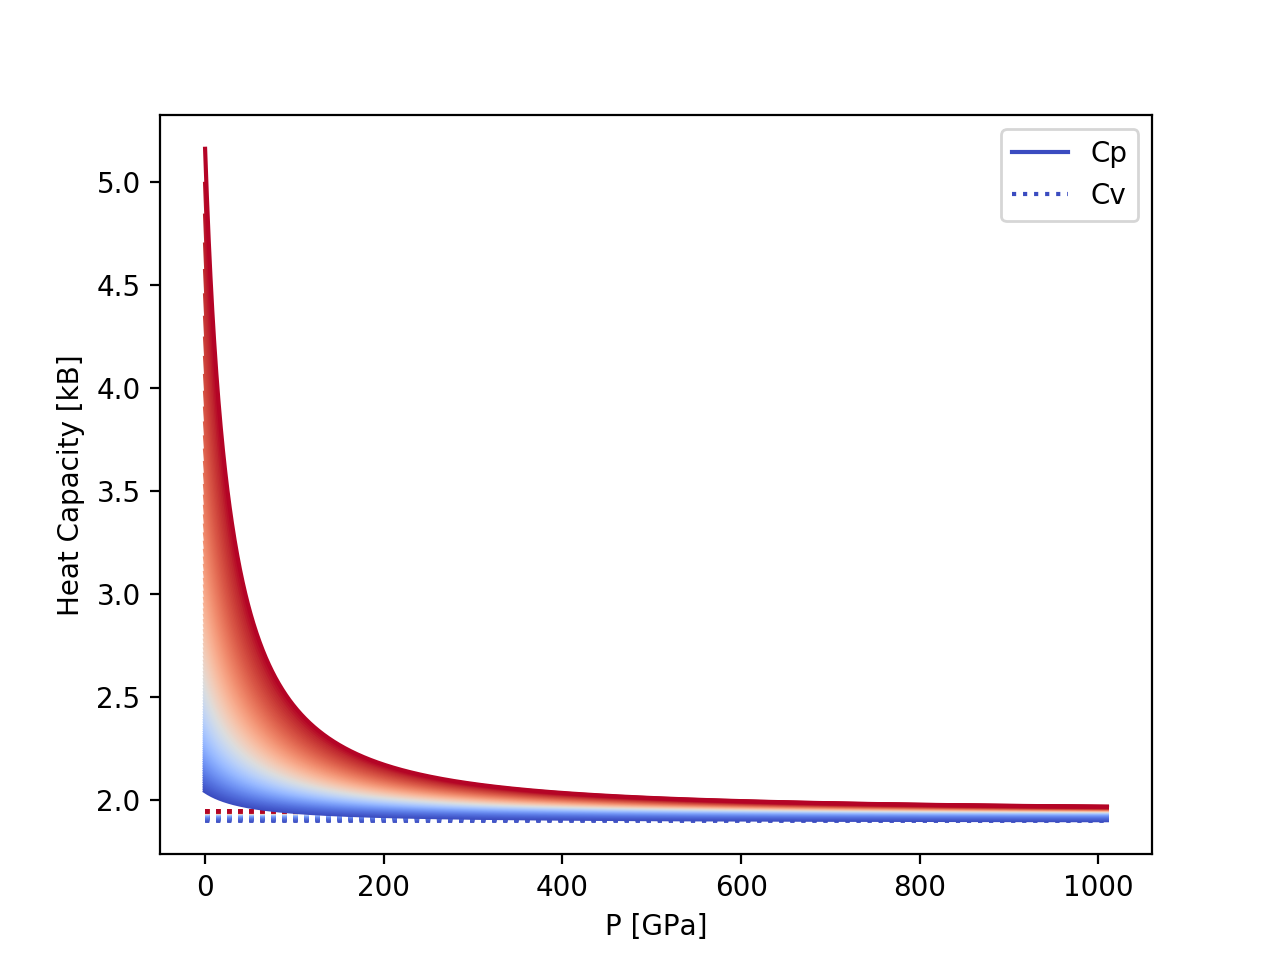

<IPython.core.display.Javascript object>


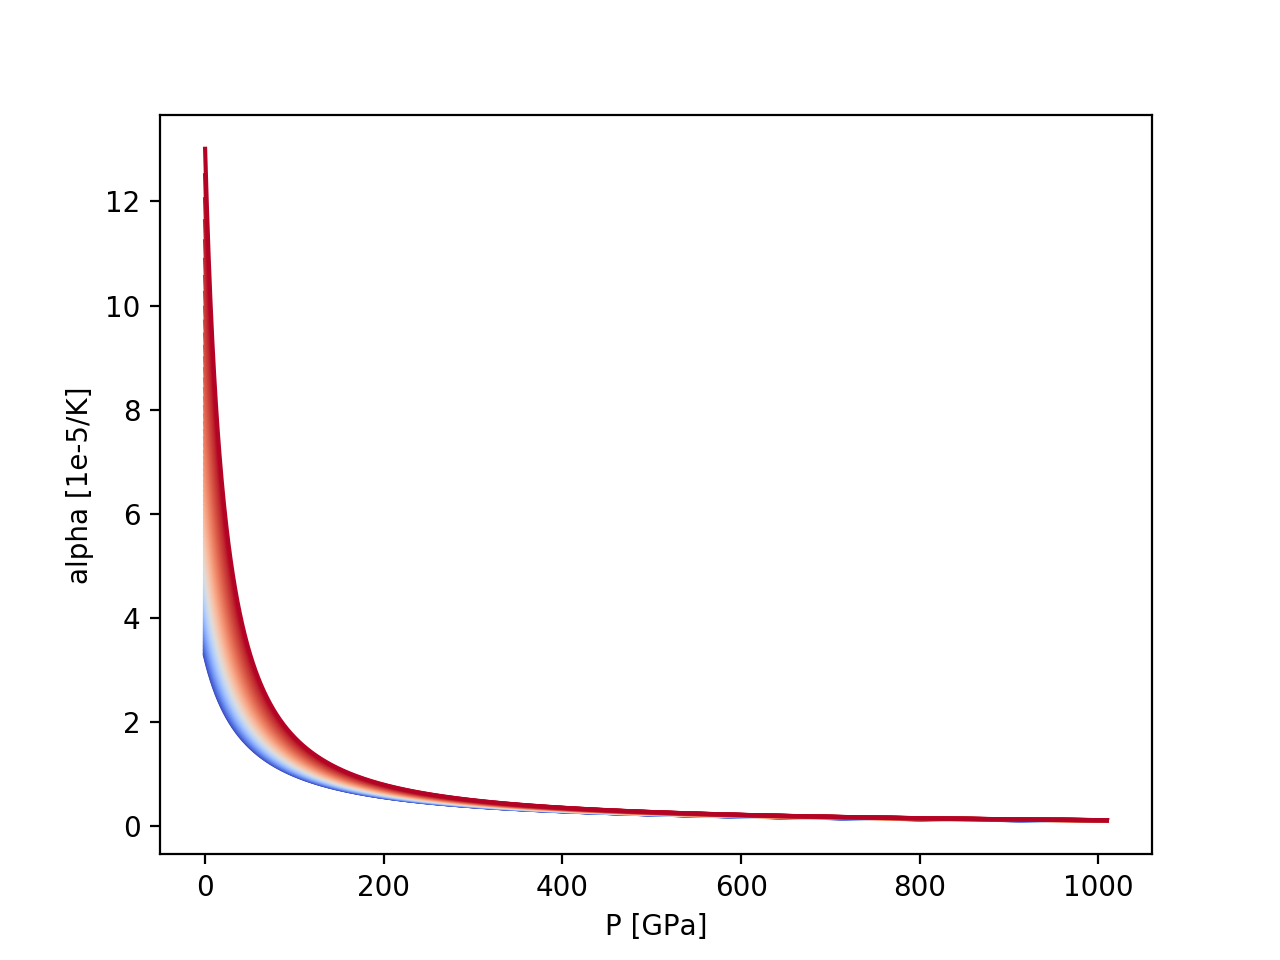

<IPython.core.display.Javascript object>


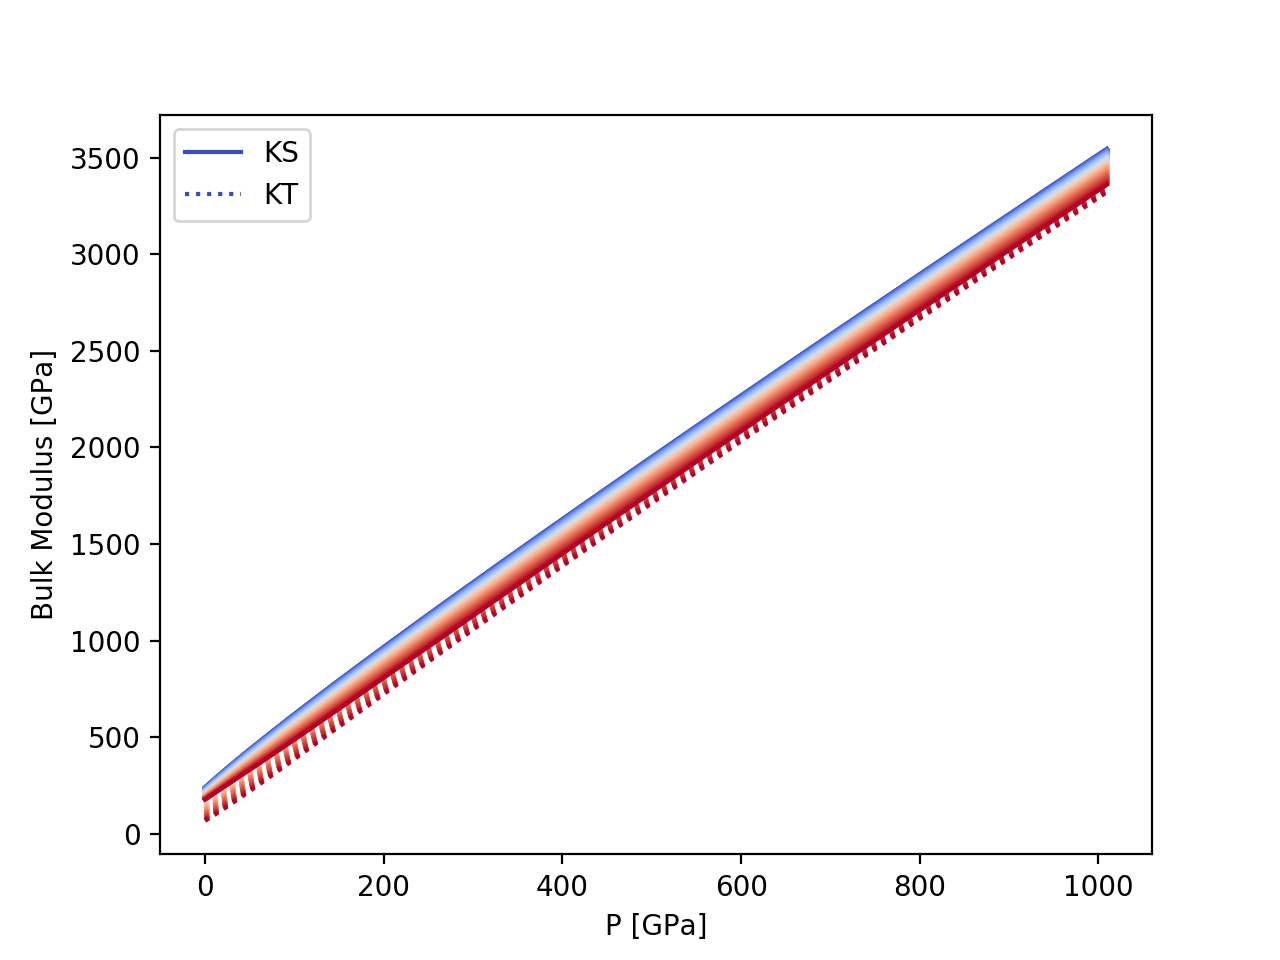

<IPython.core.display.Javascript object>


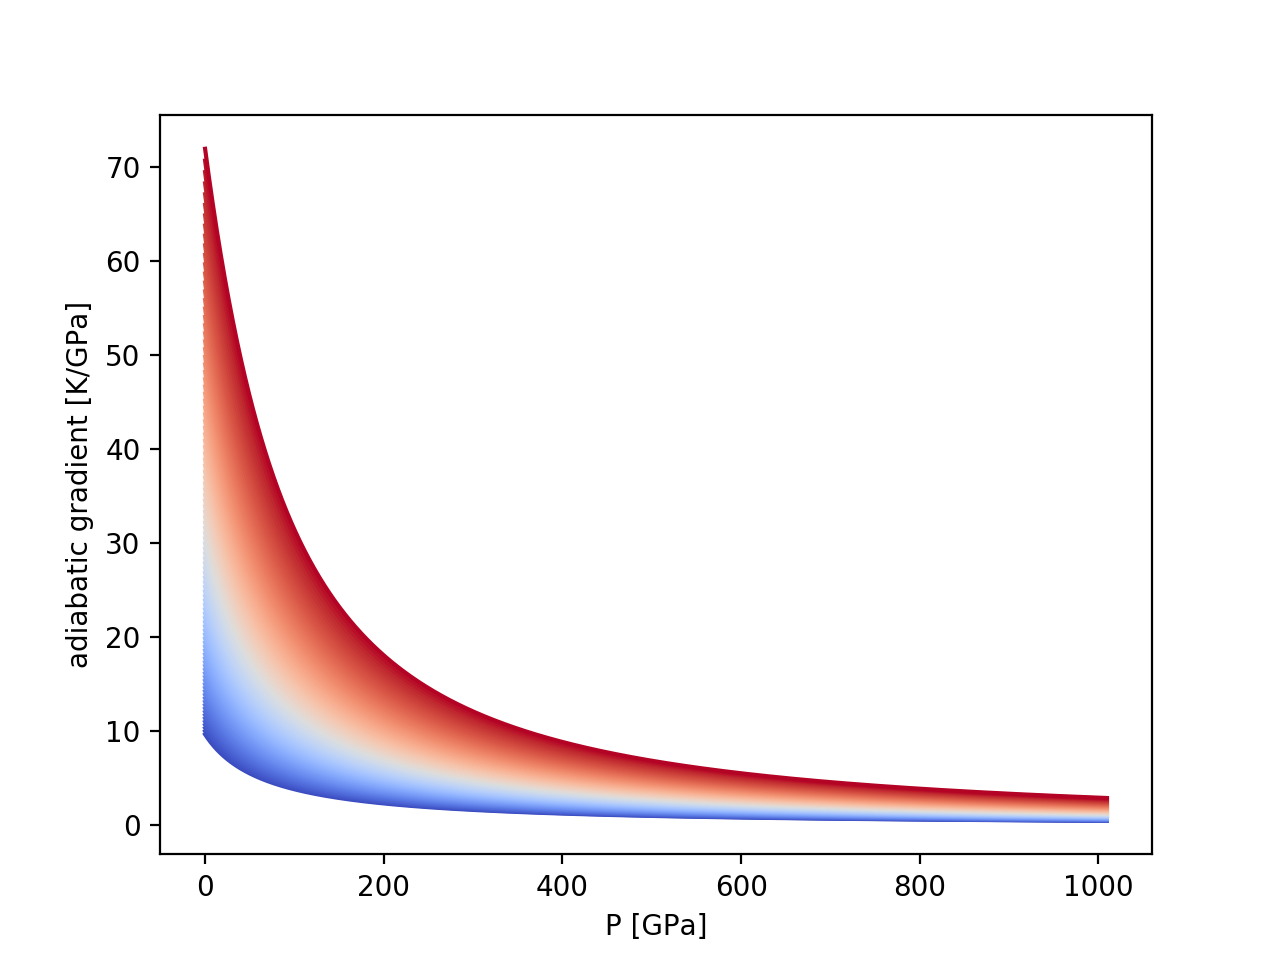

In [19]:
plt.figure()
[plt.plot(iP,irho,color=icol) for iP,irho,icol 
 in zip(props['P'],props['rho'], colors)]
plt.xlabel('P [GPa]')
plt.ylabel('rho [g/cc]')

plt.figure()
[plt.plot(iP,igamma,color=icol) for iP,igamma,icol 
 in zip(props['P'],props['gamma'], colors)]
plt.xlabel('P [GPa]')
plt.ylabel('gamma')

plt.figure()
lines_Cv = [plt.plot(iP,iCv/models.CONSTS['kboltz'],':', label='Cv', 
                     color=icol)[0] for iP,iCv,icol in 
            zip(props['P'], props['C_V'], colors)]
lines_Cp = [plt.plot(iP,iCp/models.CONSTS['kboltz'],'-', label='Cp', 
                     color=icol)[0] for iP,iCp,icol in 
            zip(props['P'], props['C_P'], colors)]

plt.xlabel('P [GPa]')
plt.ylabel('Heat Capacity [kB]')
plt.legend([lines_Cp[0],lines_Cv[0]], ['Cp','Cv'])

plt.figure()
[plt.plot(iP,ialpha*1e5,color=icol) 
 for iP,ialpha,icol in zip(props['P'], props['alpha'], colors)]
plt.xlabel('P [GPa]')
plt.ylabel('alpha [1e-5/K]')


plt.figure()
lines_KT = [plt.plot(iP,iKT,':', color=icol)[0]
 for iP,iKT,icol in zip(props['P'], props['K_T'], colors)]
lines_KS = [plt.plot(iP,iKS,'-', color=icol)[0]
 for iP,iKS,icol in zip(props['P'], props['K_S'], colors)]
plt.xlabel('P [GPa]')
plt.ylabel('Bulk Modulus [GPa]')
plt.legend([lines_KS[0],lines_KT[0]], ['KS','KT'])

plt.figure()
[plt.plot(iP,idTdPs,color=icol) 
 for iP,idTdPs,icol in zip(props['P'], props['dTdP_S'], colors)]
plt.xlabel('P [GPa]')
plt.ylabel('adiabatic gradient [K/GPa]')


In [22]:
props['T'].shape

(101, 2020)

In [23]:
props['T']

array([[ 1000.        ,  1004.78698889,  1009.53771073, ...,
         2611.76768308,  2611.97301967,  2612.17823014],
       [ 1030.        ,  1034.95259221,  1039.8676491 , ...,
         2696.1312813 ,  2696.3433513 ,  2696.55529102],
       [ 1060.        ,  1065.11972644,  1070.20064712, ...,
         2780.91863995,  2781.13748378,  2781.35619313],
       ...,
       [ 3940.        ,  3974.63212932,  4009.08274535, ...,
        15975.81503075, 15977.17504585, 15978.53418381],
       [ 3970.        ,  4005.24392477,  4040.30676261, ...,
        16281.48251317, 16282.87117737, 16284.25894493],
       [ 4000.        ,  4035.87253767,  4071.56465831, ...,
        16600.83837984, 16602.25709178, 16603.67488657]])

<IPython.core.display.Javascript object>


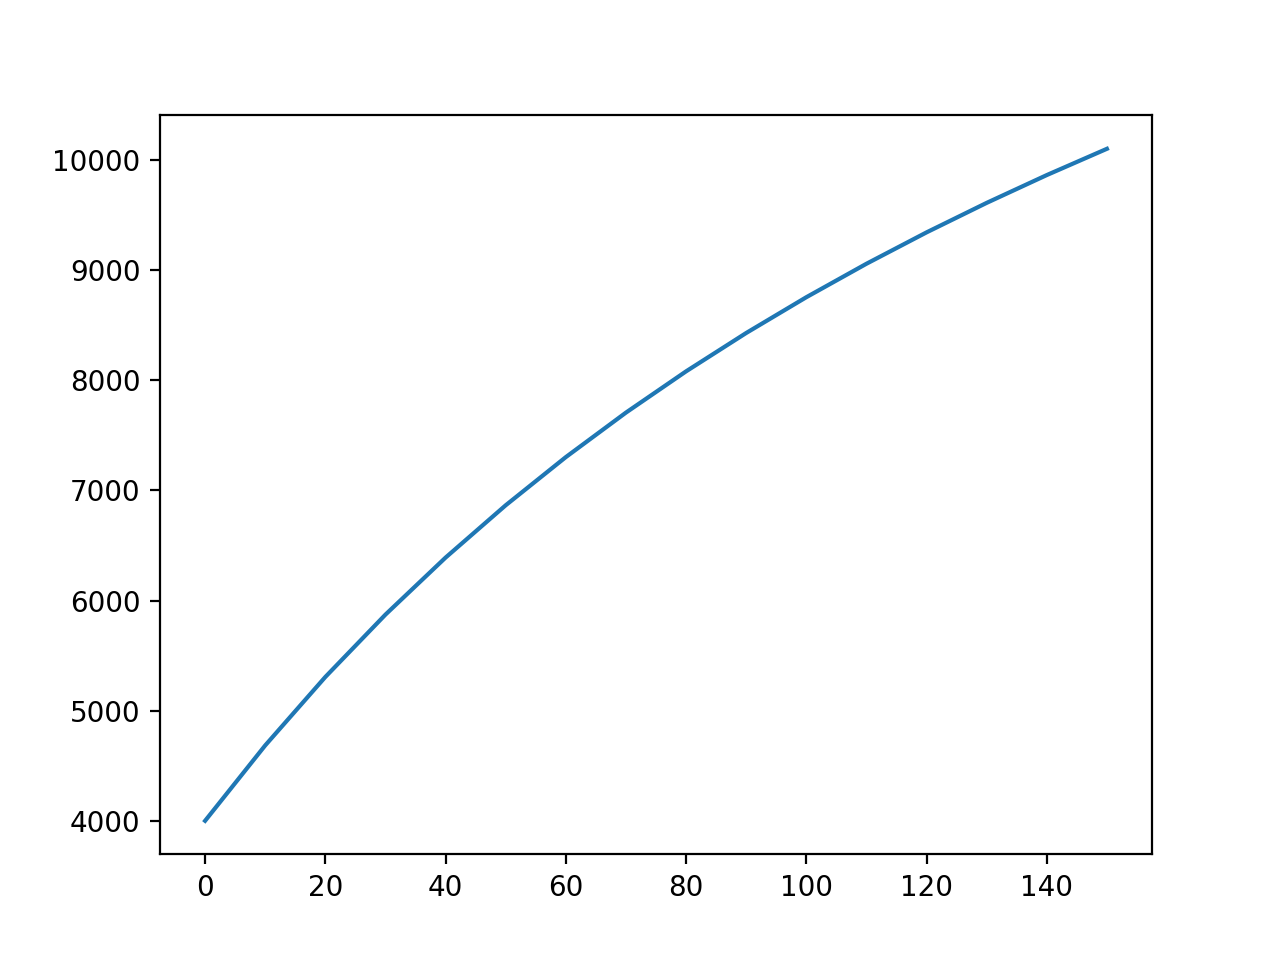

<IPython.core.display.Javascript object>


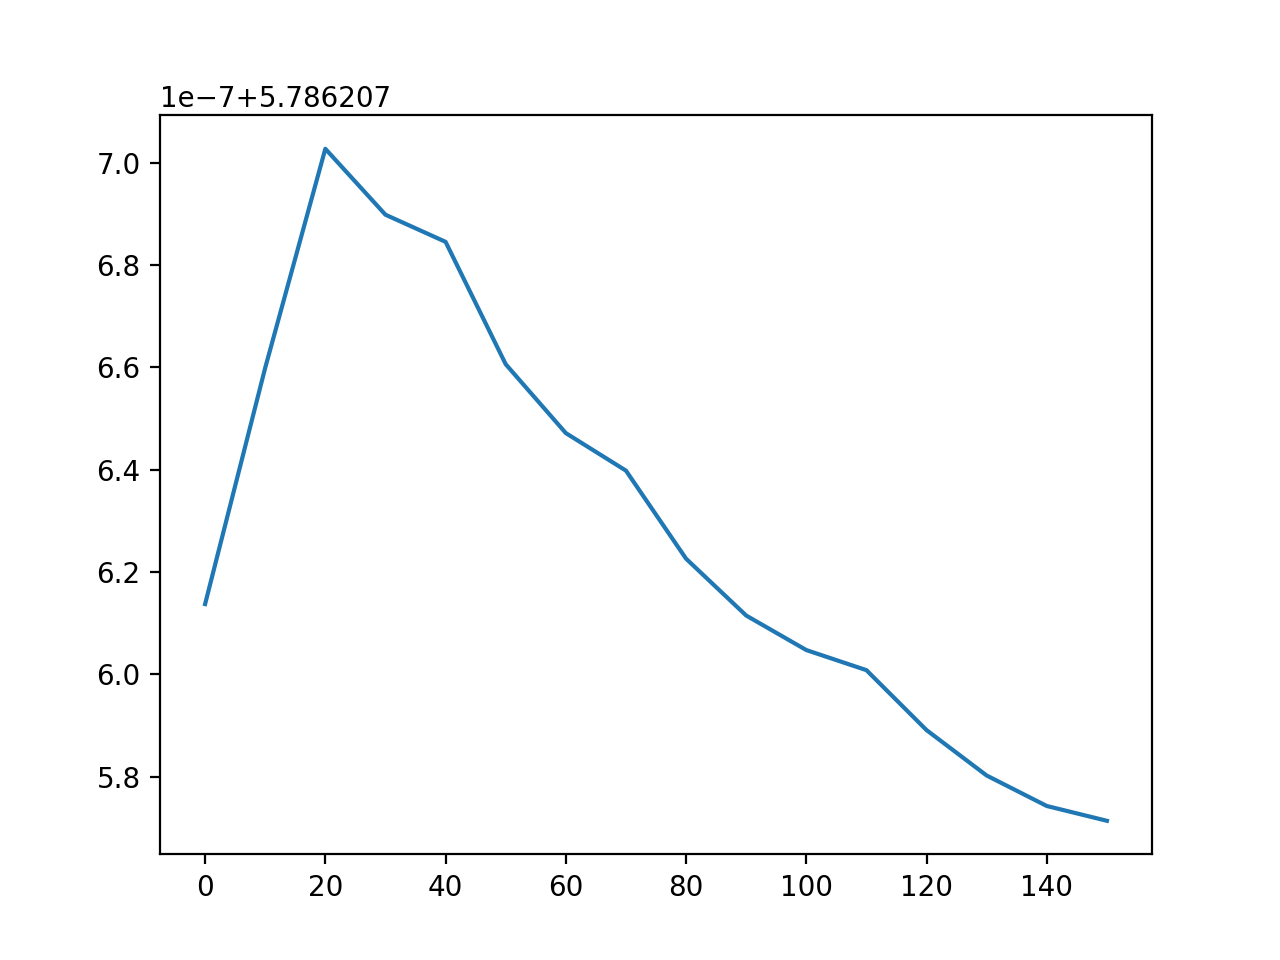

In [15]:
Pgrid = np.arange(0,150.1,10)
Vgrid, Tgrid = sol_eos.adiabatic_path(4000,Pgrid)

Sgrid = sol_eos.entropy(Vgrid, Tgrid)
plt.figure()
plt.plot(Pgrid, Tgrid, '-')

plt.figure()
plt.plot(Pgrid, Sgrid/models.CONSTS['kboltz'], '-')

<IPython.core.display.Javascript object>


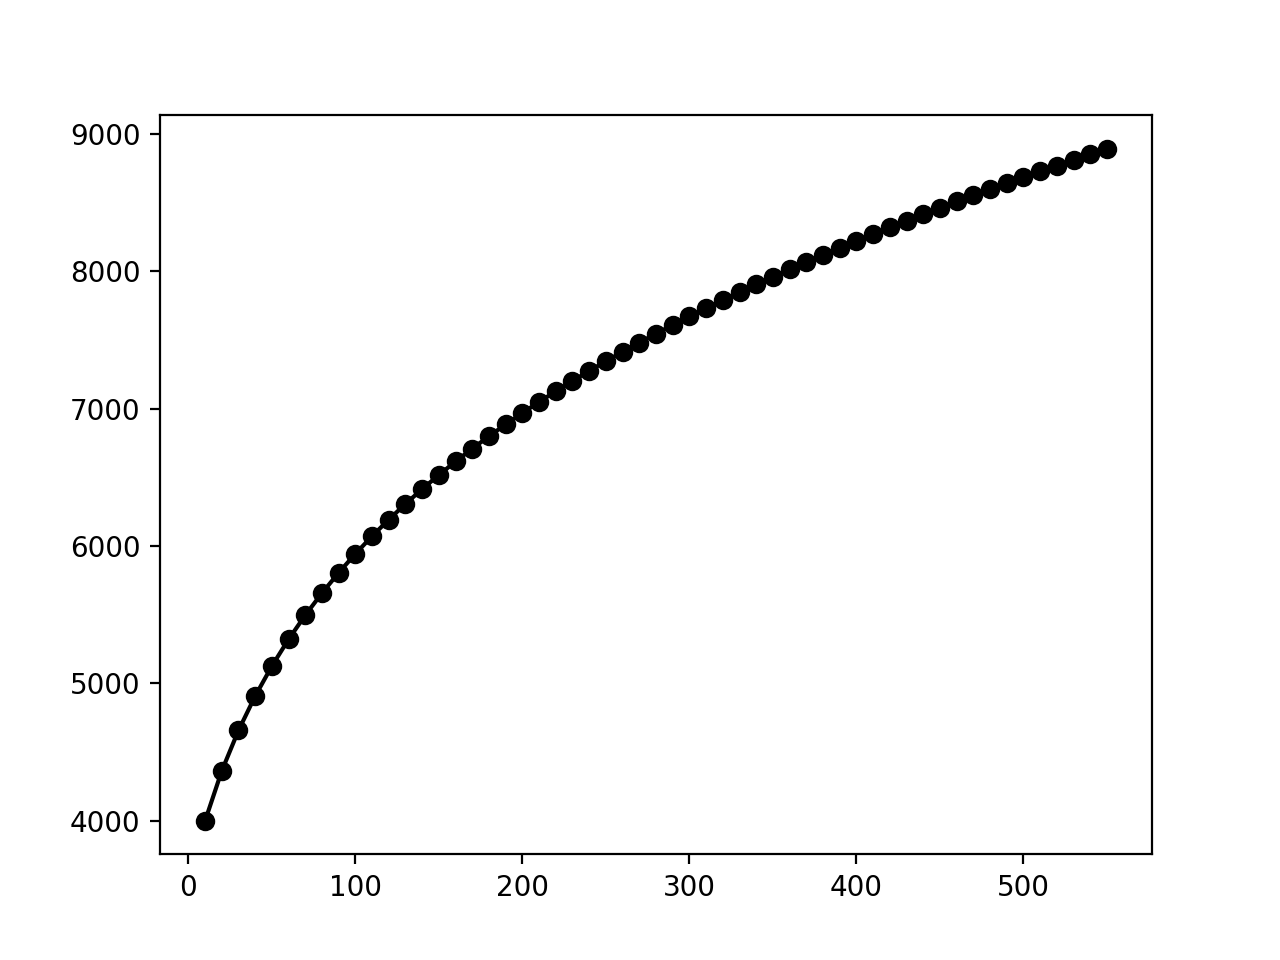

<IPython.core.display.Javascript object>


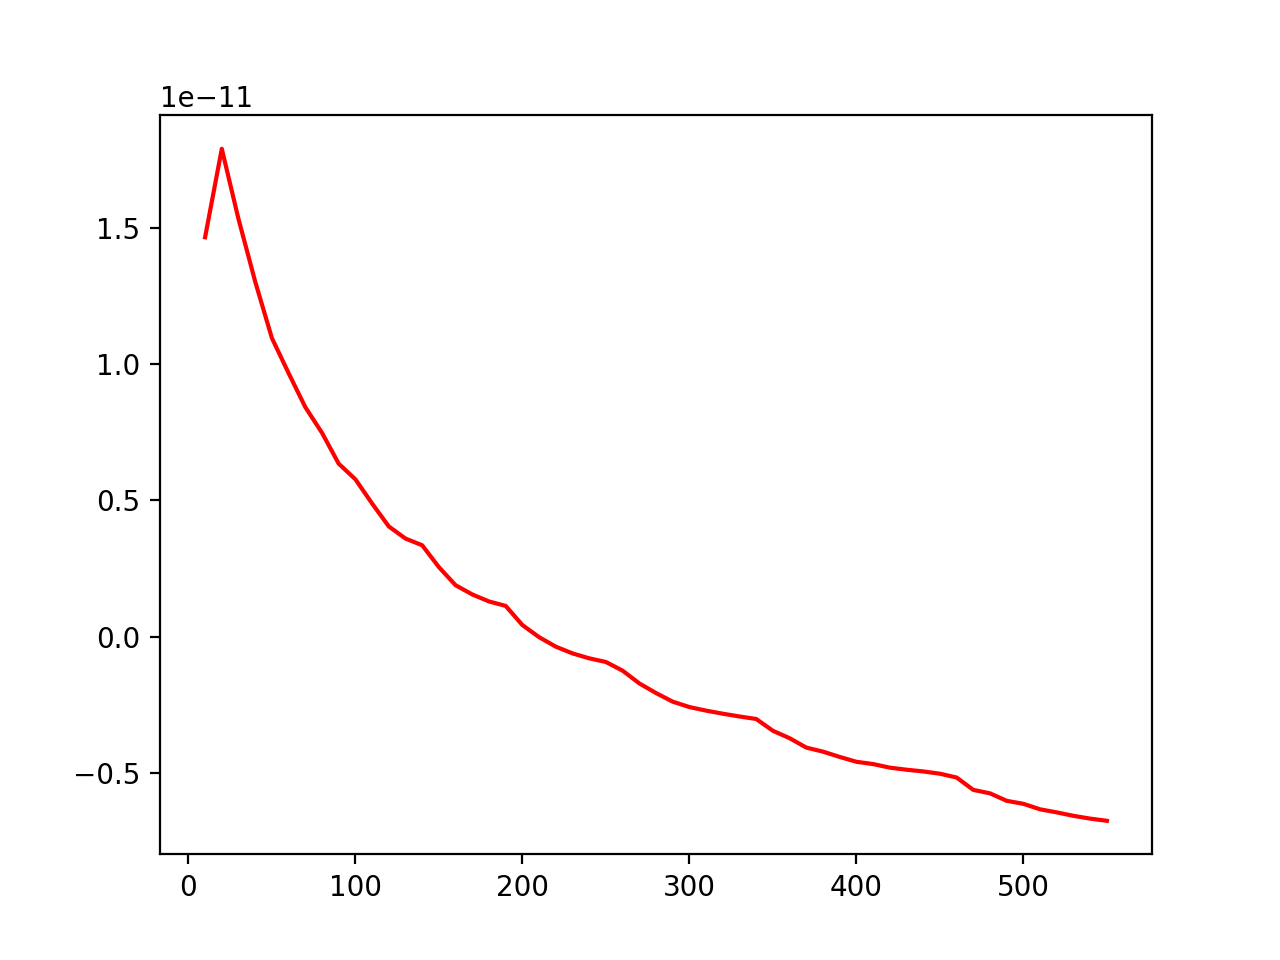

In [18]:
Pgrid = np.arange(10,550.1,10)
Vgrid, Tgrid = liq_eos_dK09.adiabatic_path(4000,Pgrid)
Sgrid = liq_eos_dK09.entropy(Vgrid, Tgrid)
plt.figure()
plt.plot(Pgrid, Tgrid, 'ko-')

plt.figure()
plt.plot(Pgrid,Sgrid-np.mean(Sgrid),'r-')

In [24]:
eos_mod.apply_electronic = False
Pgrid = np.arange(0,1.01e3,10)
Tfoot_grid = np.arange(1e3,4401,200)

#Tfoot_grid = np.arange(1e3,10.1e3,1000)
Vad_grid, Tad_grid = eos_mod.adiabatic_path_grid(Tfoot_grid,Pgrid)
props = eos_mod.material_properties(Vad_grid, Tad_grid)

In [38]:
delS = props['S']-np.mean(props['S'],1)[:,np.newaxis]
S_avg_err = np.sqrt(np.mean(delS**2))
print('Avg Entropy Error = ', S_avg_err)

Avg Entropy Error =  7.831123155351746e-12


<IPython.core.display.Javascript object>


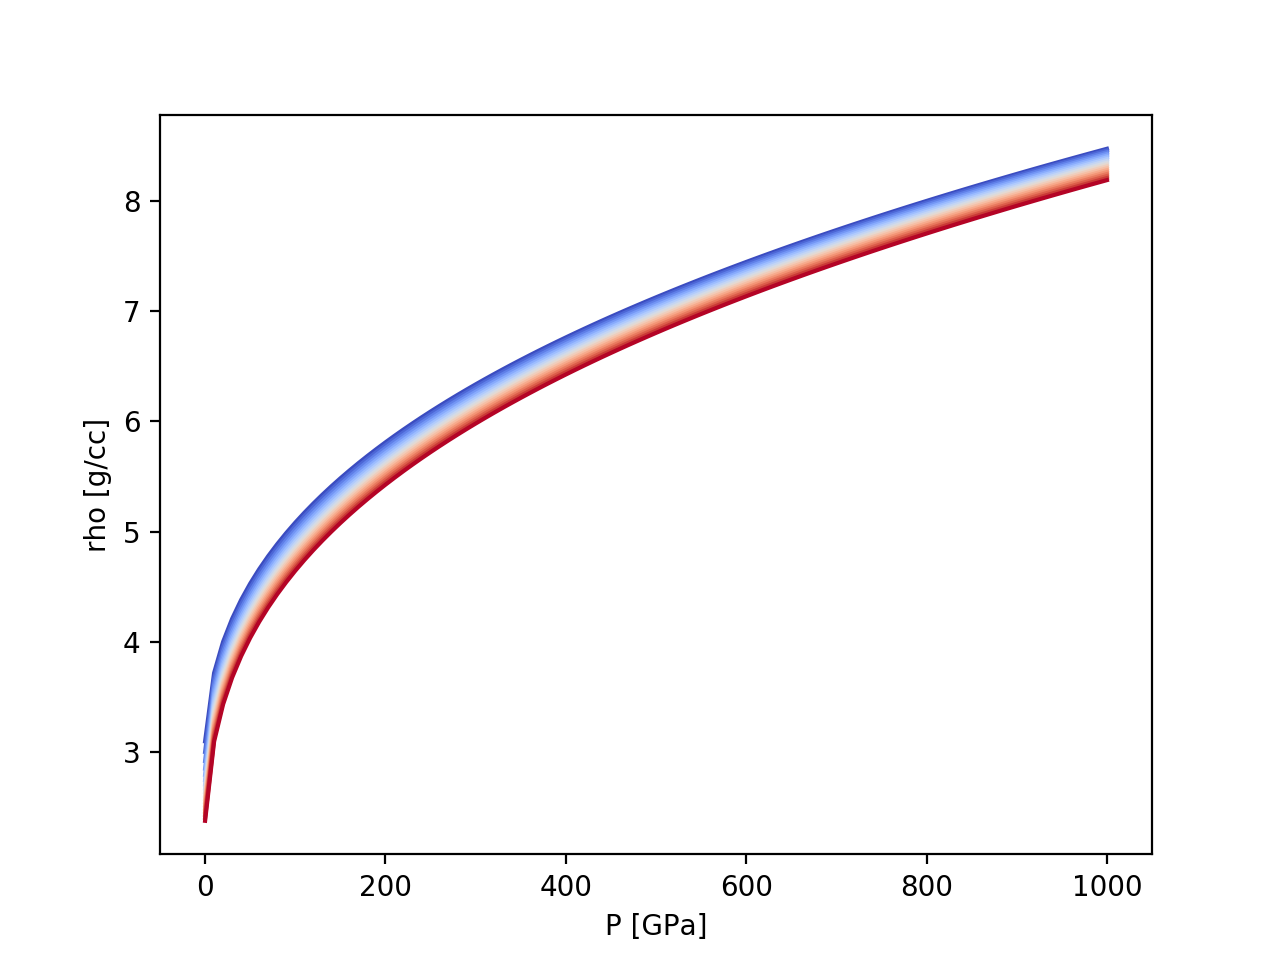

<IPython.core.display.Javascript object>


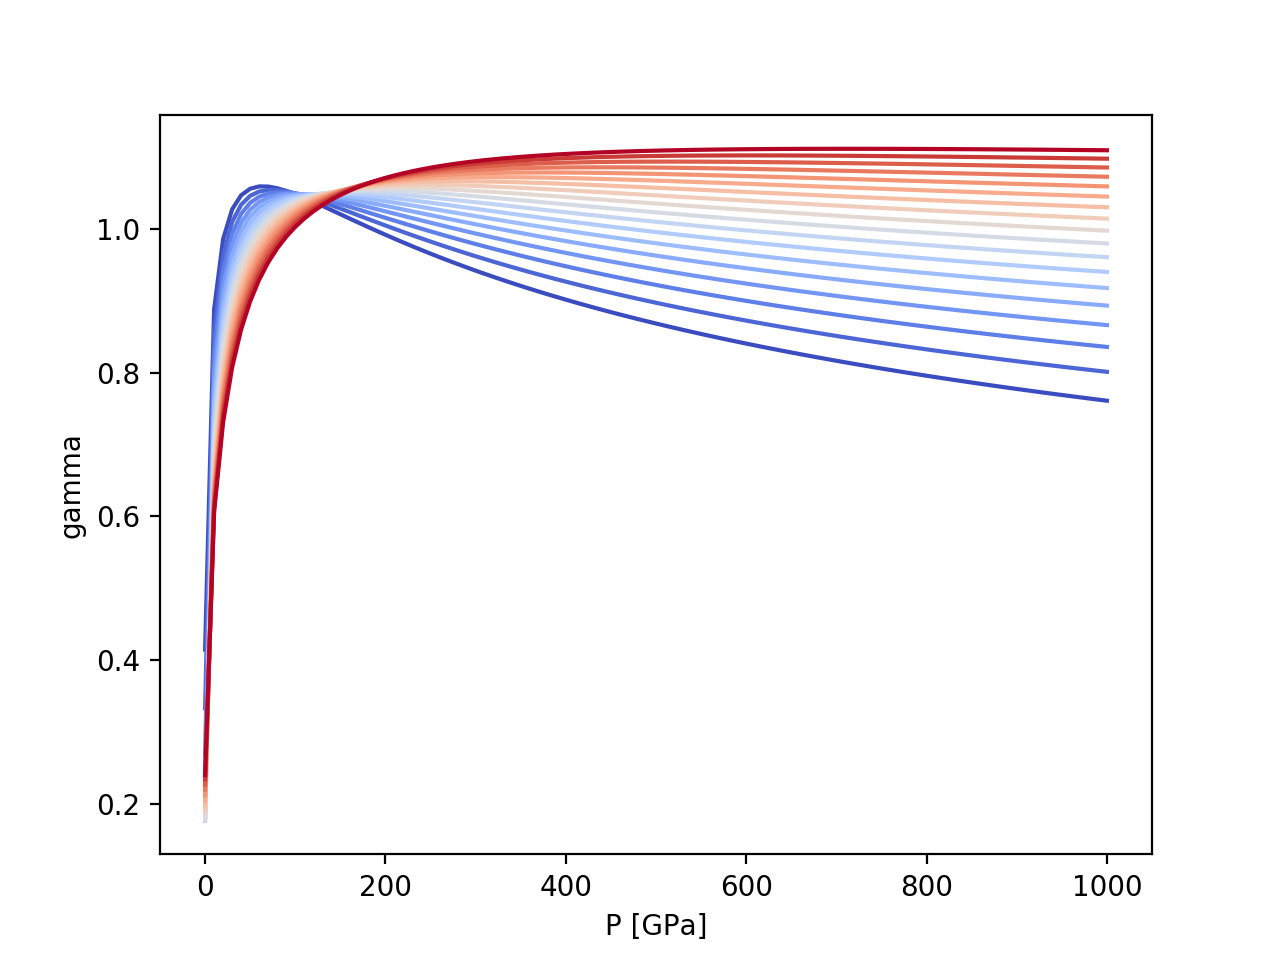

<IPython.core.display.Javascript object>


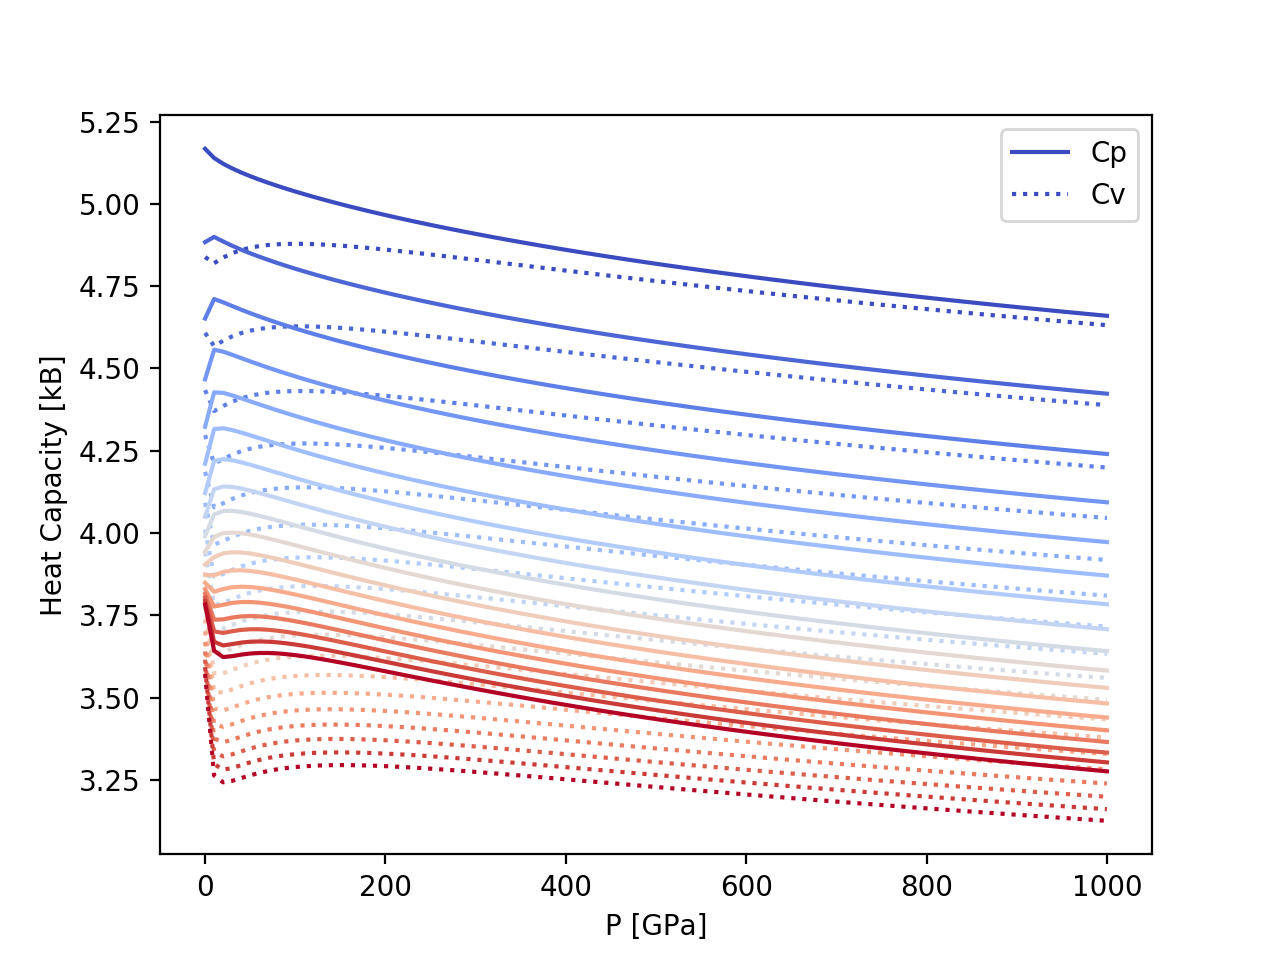

<IPython.core.display.Javascript object>


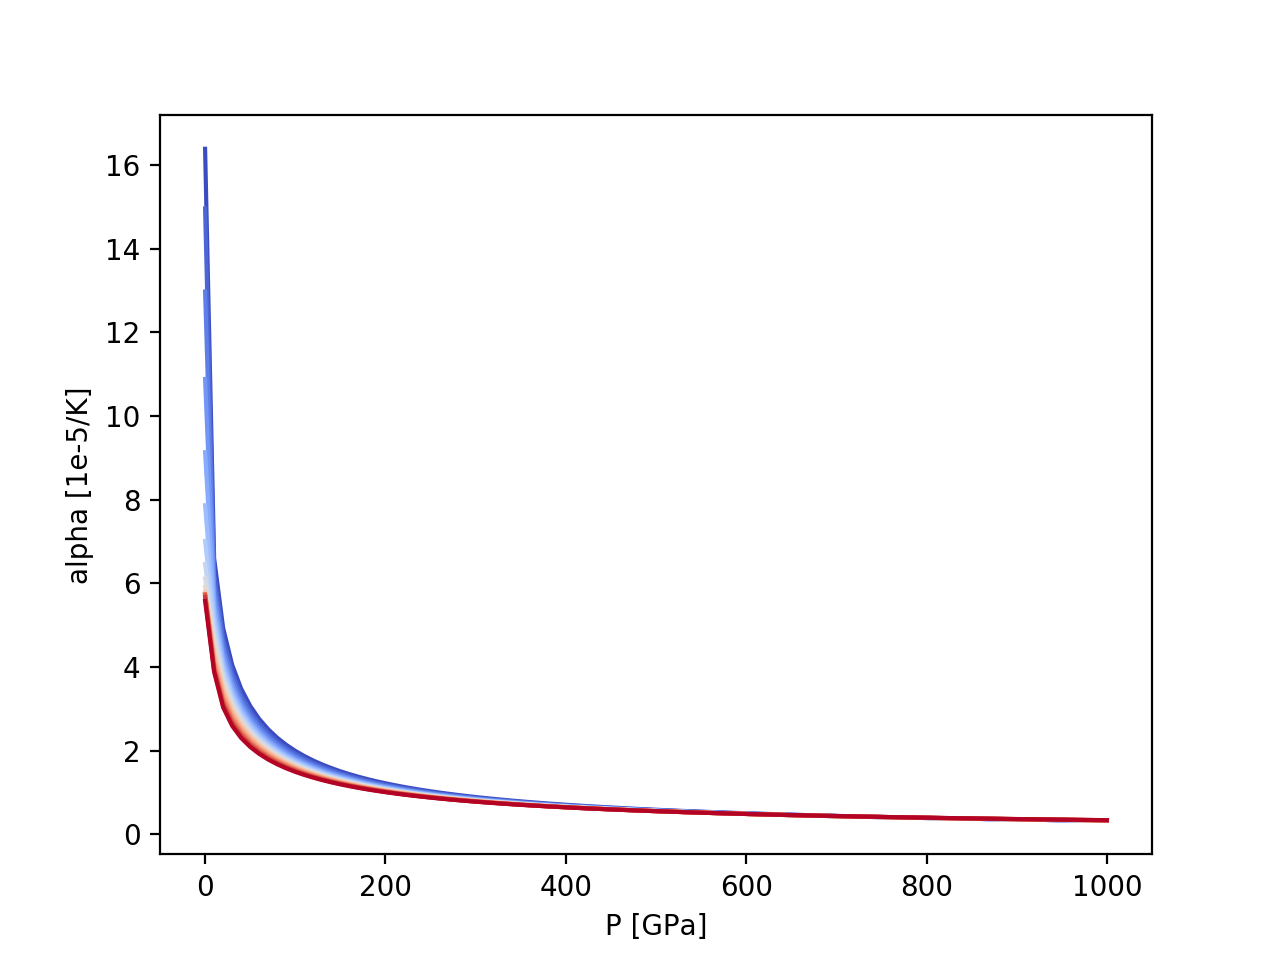

<IPython.core.display.Javascript object>


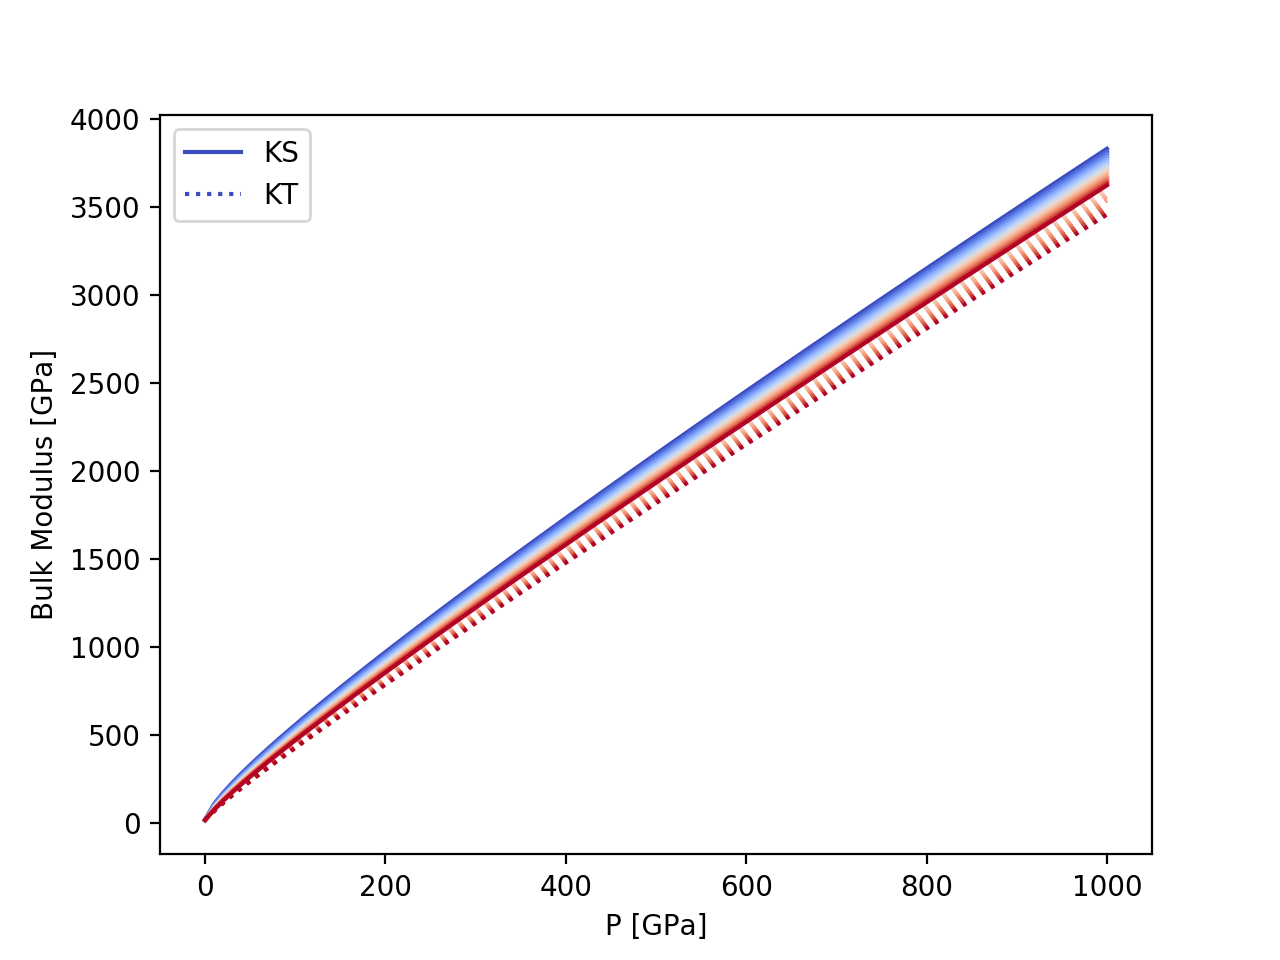

<IPython.core.display.Javascript object>


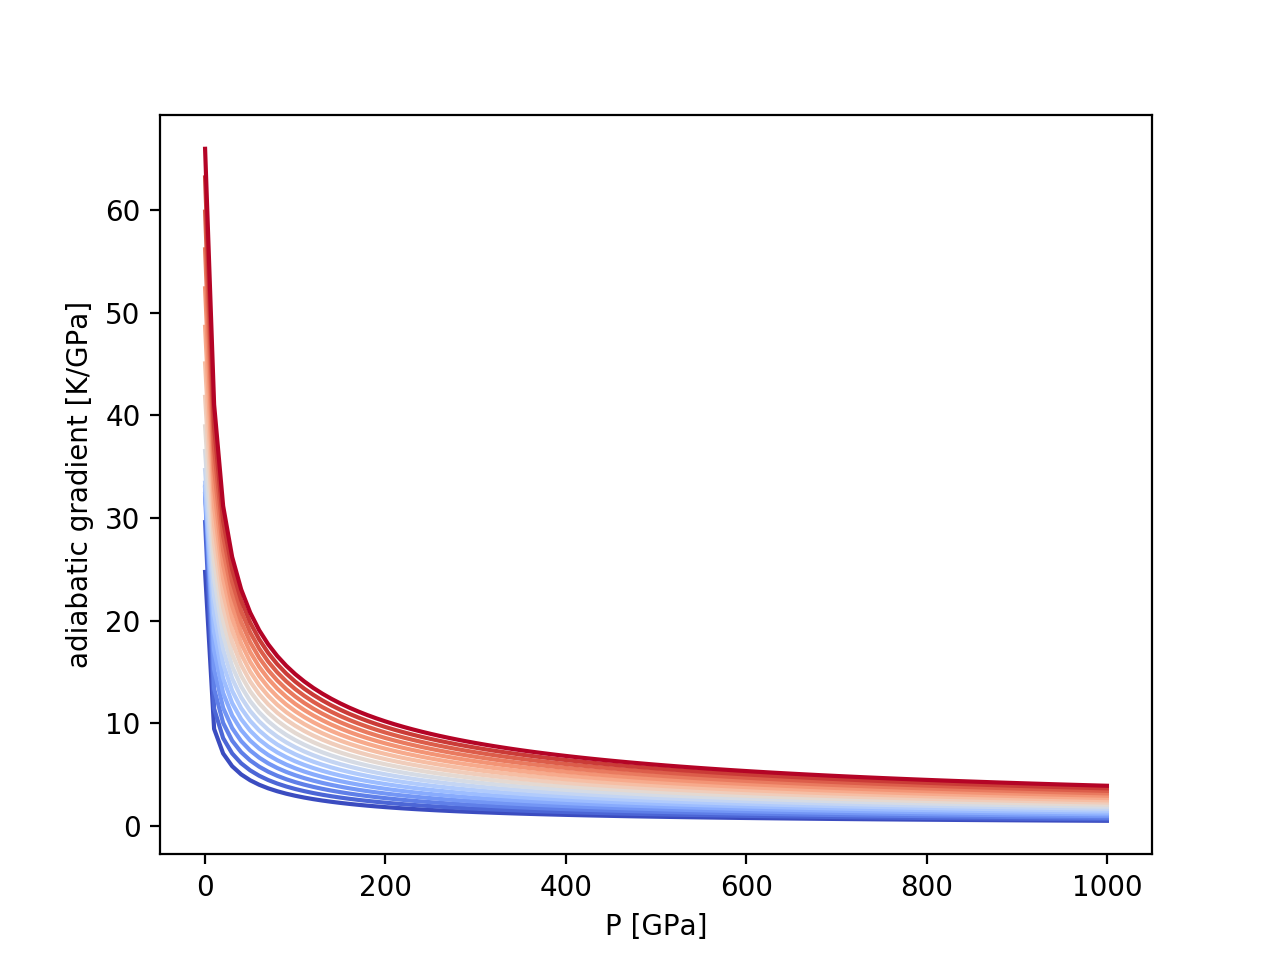

In [25]:
plt.figure()
[plt.plot(iP,irho,color=icol) for iP,irho,icol 
 in zip(props['P'],props['rho'], colors)]
plt.xlabel('P [GPa]')
plt.ylabel('rho [g/cc]')

plt.figure()
[plt.plot(iP,igamma,color=icol) for iP,igamma,icol 
 in zip(props['P'],props['gamma'], colors)]
plt.xlabel('P [GPa]')
plt.ylabel('gamma')

plt.figure()
lines_Cv = [plt.plot(iP,iCv/models.CONSTS['kboltz'],':', label='Cv', 
                     color=icol)[0] for iP,iCv,icol in 
            zip(props['P'], props['C_V'], colors)]
lines_Cp = [plt.plot(iP,iCp/models.CONSTS['kboltz'],'-', label='Cp', 
                     color=icol)[0] for iP,iCp,icol in 
            zip(props['P'], props['C_P'], colors)]

plt.xlabel('P [GPa]')
plt.ylabel('Heat Capacity [kB]')
plt.legend([lines_Cp[0],lines_Cv[0]], ['Cp','Cv'])

plt.figure()
[plt.plot(iP,ialpha*1e5,color=icol) 
 for iP,ialpha,icol in zip(props['P'], props['alpha'], colors)]
plt.xlabel('P [GPa]')
plt.ylabel('alpha [1e-5/K]')


plt.figure()
lines_KT = [plt.plot(iP,iKT,':', color=icol)[0]
 for iP,iKT,icol in zip(props['P'], props['K_T'], colors)]
lines_KS = [plt.plot(iP,iKS,'-', color=icol)[0]
 for iP,iKS,icol in zip(props['P'], props['K_S'], colors)]
plt.xlabel('P [GPa]')
plt.ylabel('Bulk Modulus [GPa]')
plt.legend([lines_KS[0],lines_KT[0]], ['KS','KT'])

plt.figure()
[plt.plot(iP,idTdPs,color=icol) 
 for iP,idTdPs,icol in zip(props['P'], props['dTdP_S'], colors)]
plt.xlabel('P [GPa]')
plt.ylabel('adiabatic gradient [K/GPa]')


In [27]:
props.keys()

odict_keys(['V', 'T', 'rho', 'alpha', 'gamma', 'S', 'P', 'C_V', 'C_P', 'K_T', 'K_S', 'dTdP_S'])

In [40]:
props['C_P']/models.CONSTS['kboltz']

array([[5.16759602, 5.1396452 , 5.12226263, ..., 4.66522641, 4.6626345 ,
        4.66006068],
       [4.88399223, 4.89988521, 4.88600381, ..., 4.42851863, 4.42594678,
        4.42339324],
       [4.65184143, 4.71106079, 4.70121876, ..., 4.2452529 , 4.24269534,
        4.24015633],
       ...,
       [3.80328029, 3.70088499, 3.69643224, ..., 3.33773481, 3.33519665,
        3.33267859],
       [3.79309251, 3.66948565, 3.65833931, ..., 3.3080834 , 3.30554365,
        3.30302402],
       [3.78296533, 3.64227332, 3.62311215, ..., 3.28087816, 3.27833703,
        3.27581601]])